In [2]:
import numpy as np
from datetime import datetime
import time
import torch, os, copy
from scipy.ndimage import affine_transform
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import trange, tqdm
from matplotlib import colormaps
import nibabel as nib
from PIL import Image
import json
from torchvision.ops._utils import _upcast
from torch_scatter import scatter_max
from cpd_translation import RigidRegistration

ZRANGE = 5
OVERLAP_R = 0.2

In [3]:
ptag='pair4' 
btag='220904_L35D719P5_topro_brn2_ctip2_4x_0_108na_50sw_11hdf_4z_20ov_21-49-38'
# btag='220902_L35D719P3_topro_brn2_ctip2_4x_11hdf_0_108na_50sw_4z_20ov_16-41-36'
# ptag='pair19'
# btag='220911_L79D769P8_topro_brn2_ctip2_4x_0_108na_50sw_11hdf_4z_20ov_18-27-26'
device = 'cuda:3'

In [4]:

def bbox_in_stitching_seam(bbox, lt_loc, wh, i, j, ncol, nrow, nms_r):
    # mask = [left, right, bottom, top]
    masks = [None, None, None, None]
    if i > 0:
        # 0 ~ overlap_r
        mask = bbox[:, 1] < lt_loc[0] + wh[0]*(nms_r)
        masks[0] = mask

    if i < ncol-1:
        # 1-overlap_r ~ 1
        mask = bbox[:, 4] > lt_loc[0] + wh[0]*(1-nms_r)
        masks[1] = mask

    if j > 0:
        # 0 ~ overlap_r
        mask = bbox[:, 2] < lt_loc[1] + wh[1]*nms_r
        masks[2] = mask

    if j < nrow-1:
        # 1-overlap_r ~ 1
        mask = bbox[:, 5] > lt_loc[1] + wh[1]*(1-nms_r)
        masks[3] = mask

    return masks

def coord_to_bbox(coord, vol, device):
    if (vol == 0).any():
        print('Exist NIS has zero volume')
        valid_nis = vol!=0
        vol_cumsum = vol.cumsum(0)
        vol_cumsum = [0] + vol_cumsum.tolist()
        valid_nis = torch.where(valid_nis)[0]
        valid_coord = []
        for i in valid_nis:
            valid_coord.append(torch.arange(vol_cumsum[i], vol_cumsum[i+1]))
            assert valid_coord[-1].shape[0] == vol[i], f'{i}: {valid_coord[-1].shape[0]} != {vol[i]}, {vol_cumsum[i-1]}, {vol_cumsum[i]}, {vol_cumsum[i+1]}'

        valid_coord = torch.cat(valid_coord)
        vol = vol[valid_nis]
        coord = coord[valid_coord]

    coord_list = torch.tensor_split(coord, vol.cumsum(0)[:-1].cpu(), dim=0)
    lrange = 100000
    bboxs = []
    for i in range(0, len(coord_list), lrange):
        coord = torch.nn.utils.rnn.pad_sequence(coord_list[i:i+lrange], batch_first=True).to(device)
        assert coord.shape[1] == vol[i:i+lrange].max(), f'{coord.shape[1]} != {vol[i:i+lrange].max()}'
        coord_sort = coord.sort(dim=1, descending=True)[0]
        coord_min = coord_sort[torch.arange(coord_sort.shape[0]), vol[i:i+lrange]-1, :] # N x 3
        coord_max = coord_sort[:, 0] # N x 3
        assert (coord_min!=0).any(), 'coord_min is all zero'
        bbox = torch.cat([coord_min, coord_max], 1) # N x 6
        bboxs.append(bbox)
    bboxs = torch.cat(bboxs)
    return bboxs

def nms_bbox(bbox_tgt, bbox_mov, iou_threshold=0.1):
    D = int(bbox_mov.shape[1]/2)
    area_tgt = box_area(bbox_tgt, D)
    area_mov = box_area(bbox_mov, D)
    iou, index = box_iou(bbox_tgt, bbox_mov, D, area1=area_tgt, area2=area_mov)
    ## scatter max among each of mov bbox (use this)
    max_iou, argmax = scatter_max(iou, index[1])
    ## scatter max among each of tgt bbox
    # max_iou, argmax = scatter_max(iou, index[0])
    ## max iou larger than threshold
    big_iou = max_iou >= iou_threshold
    remove_ind_mov = index[1, argmax[big_iou]]
    remove_ind_tgt = index[0, argmax[big_iou]]
    ## remove small area of tgt or mov bbox
    remove_area_tgt = area_tgt[remove_ind_tgt] 
    remove_area_mov = area_mov[remove_ind_mov] 
    remove_ind_tgt = remove_ind_tgt[remove_area_tgt < remove_area_mov].unique()
    remove_ind_mov = remove_ind_mov[remove_area_mov <= remove_area_tgt].unique()
    return remove_ind_tgt, remove_ind_mov

def box_iou(boxes1, boxes2, D=2, area1=None, area2=None):
    if area1 is None:
        area1 = box_area(boxes1, D)
    if area2 is None:
        area2 = box_area(boxes2, D)
    index = []
    inter = []
    lrange = 500
    # for i in trange(0, len(boxes1), lrange, desc=f'Compute IoU between {boxes1.shape} and {boxes2.shape} boxes'):
    for i in range(0, len(boxes1), lrange):
        lt = torch.max(boxes1[i:i+lrange, None, :D], boxes2[:, :D])  # [N,M,D]
        rb = torch.min(boxes1[i:i+lrange, None, D:], boxes2[:, D:])  # [N,M,D]
        ind1, ind2 = torch.where((rb > lt).all(dim=-1))
        # if len(ind1) == 0: continue
        wh = _upcast(rb[ind1, ind2] - lt[ind1, ind2])
        assert (wh>0).all()
        inter.append(wh.cumprod(-1)[..., -1]) # [N*M]
        ind1 = ind1 + i
        index.append(torch.stack([ind1, ind2])) # [2, N*M]
    
    inter = torch.cat(inter)
    index = torch.cat(index, 1)
    union = area1[index[0]] + area2[index[1]] - inter
    iou = inter / union
    return iou, index

def box_area(bbox, D):
    bbox = _upcast(bbox)
    wh = bbox[:, D:] - bbox[:, :D]
    return torch.cumprod(wh, dim=1)[:, -1]

class image_stitch_QCer:
    def __init__(self, seg_shape, overlap_w, overlap_h):
        x_grad1 = torch.cat([torch.arange(overlap_w).float() / overlap_w, 
            torch.ones(seg_shape[1]-2*overlap_w),
            torch.arange(overlap_w, 0, -1) / overlap_w])

        y_grad1 = torch.cat([torch.arange(overlap_h).float() / overlap_h, 
            torch.ones(seg_shape[2]-2*overlap_h),
            torch.arange(overlap_h, 0, -1) / overlap_h])

        self.mov_adaptive_grad = x_grad1[:, None] * y_grad1[None, :]

        x_grad2 = torch.cat([torch.arange(overlap_w, 0, -1) / overlap_w, 
            torch.zeros(seg_shape[1]-2*overlap_w),
            torch.arange(overlap_w).float() / overlap_w])

        y_grad2 = torch.cat([torch.arange(overlap_h, 0, -1) / overlap_h, 
            torch.zeros(seg_shape[2]-2*overlap_h),
            torch.arange(overlap_h).float() / overlap_h])

        self.tgt_adaptive_grad = x_grad2[:, None] * y_grad1[None, :] + x_grad1[:, None] * y_grad2[None, :] + x_grad2[:, None] * y_grad2[None, :]

    def adaptive_image_stitch(self, mov_overlap, tgt_overlap, overlap_mask):
        overlap_coord = np.where(overlap_mask)
        if len(overlap_coord) == 3:
            _, ox, oy = overlap_coord
        else:
            ox, oy = overlap_coord
            
        mov = self.mov_adaptive_grad[ox, oy].numpy() * mov_overlap
        tgt = self.tgt_adaptive_grad[ox, oy].numpy() * tgt_overlap
        return (mov + tgt)
        

def distance_mat(pt1, pt2):
    lrange = 100
    min_dis = []
    for li in range(0, len(pt1), lrange):
        d = pt1[li:li+lrange, None, :] - pt2[None, :, :]
        d = (d**2).sum(-1).sqrt()
        min_d = d.min(1)[0]
        min_dis.append(min_d)
    min_dis = torch.cat(min_dis)
    return min_dis

def plot_pts(pt_list):
    plt.figure(figsize=(20,20))
    for pi, pt in enumerate(pt_list):
        pt = pt[pt[:,0]==0, 1:]
        ax = sns.scatterplot(x=pt[:,0], y=pt[:,1], s=3, cmap='tab19', alpha=0.5)

def point_overlap_index(pt_mov, pt_tgt, extend_r=0):
    range_mov = list(pt_mov.min(0)[0]*(1-extend_r)) + list(pt_mov.max(0)[0]*(1+extend_r))
    range_tgt = list(pt_tgt.min(0)[0]*(1-extend_r)) + list(pt_tgt.max(0)[0]*(1+extend_r))
    pmask_tgt = torch.logical_and(torch.logical_and(pt_tgt[:, 0]>=range_mov[0], pt_tgt[:, 1]>=range_mov[1]),
                                 torch.logical_and(pt_tgt[:, 0]<=range_mov[2], pt_tgt[:, 1]<=range_mov[3]))
    pmask_mov = torch.logical_and(torch.logical_and(pt_mov[:, 0]>=range_tgt[0], pt_mov[:, 1]>=range_tgt[1]),
                                 torch.logical_and(pt_mov[:, 0]<=range_tgt[2], pt_mov[:, 1]<=range_tgt[3]))
    return pmask_mov, pmask_tgt
    
def point_reg_cpd(pt_mov, pt_tgt, only_overlap=True, device='cpu', **kargs):
    if only_overlap:
        pmask_mov, pmask_tgt = point_overlap_index(pt_mov, pt_tgt)
        pt_tgt = pt_tgt[pmask_tgt].float()
        pt_mov = pt_mov[pmask_mov].float()
        
    # create a RigidRegistration object
    reg = RigidRegistration(X=pt_tgt.numpy(), Y=pt_mov.numpy(), device=device, tolerance=0.00001, **kargs)
    # run the registration & collect the results
    TY, (s_reg, R_reg, t_reg) = reg.register()
    correspondence = reg.P
    del reg
    return s_reg, R_reg, t_reg, correspondence




In [6]:
'''
Prepare NIS center for coarse stitching
'''
gpu_cap_pt_num = 32000
zratio = 2.5/4
# zranges = [5, 10, 15, 20, 25, 30]
zrange = ZRANGE
# zmiddle = 500
overlap_r = OVERLAP_R
down_r = 1 # according to zrange, downsample points to speed up point registration

save_path = f'/cajal/ACMUSERS/ziquanw/Lightsheet/stitch_by_ptreg/{ptag}/{btag.split("_")[1]}'
result_path = f'/cajal/ACMUSERS/ziquanw/Lightsheet/results/P4/{ptag}/{btag}'
tile_loc = np.array([[int(fn[8:10]), int(fn[-3:-1])] for fn in os.listdir(result_path)])
ncol, nrow = tile_loc.max(0)+1
# print(tile_loc, nrow, ncol)
assert len(tile_loc) == nrow*ncol, f'tile of raw data is not complete, tile location: {tile_loc}'

ls_image_root = f'/lichtman/Felix/Lightsheet/P4/{ptag}/{btag}'
fn_ = ls_image_root.split('_')[-1]+'_'+'_'.join(btag.split('_')[1:-1])

os.makedirs(save_path, exist_ok=True)
os.makedirs(f'{save_path}/LS_image', exist_ok=True)
os.makedirs(f'{save_path}/NIS_tranform', exist_ok=True)
os.makedirs(f'{save_path}/doubled_NIS_label', exist_ok=True)
root = result_path + '/UltraII[%02d x %02d]'
stack_names = [f for f in os.listdir(root % (0, 0)) if f.endswith('instance_center.zip')]
neighbor = [[-1, 0], [0, -1], [-1, -1], [1, 0], [0, 1], [1, 1], [1, -1], [-1, 1]]
tile_ind = []
for j in range(nrow):
    for i in range(ncol):
        tile_ind.append(f'{i}-{j}')

In [7]:
stack_names

['L35D719P5_NIScpp_results_zmin0_instance_center.zip',
 'L35D719P5_NIScpp_results_zmin958_instance_center.zip']

In [6]:
# stack_name = stack_names[-1]

In [7]:
org_tile_pts = {}
for stack_name in stack_names:
    print(stack_name)
    meta_name = stack_name.replace('instance_center', 'seg_meta')
    zstart = int(stack_name.split('zmin')[1].split('_')[0])
    zstart = int(zstart*zratio)
    seg_shape = torch.load(f'{root % (0, 0)}/{meta_name}')
    zend = int(zstart + seg_shape[0].item()*zratio)
    tile_w = int(seg_shape[1].item()*(1-overlap_r))
    tile_h = int(seg_shape[2].item()*(1-overlap_r))
    overlap_w = int(seg_shape[1].item()*overlap_r)
    overlap_h = int(seg_shape[2].item()*overlap_r)
    org_tile_pt = {}
    for i in trange(ncol, desc='Load NIS centers'):
        for j in range(nrow):
            fn = f'{root % (i, j)}/{stack_name}'
            assert os.path.exists(fn), f'results not exist, {fn}'
            pt = torch.load(fn).long()
            pt[:, 0] = (pt[:, 0] * zratio) + zstart#.long()
            pt[:, 1] = pt[:, 1] + i*seg_shape[1]*(1-overlap_r)
            pt[:, 2] = pt[:, 2] + j*seg_shape[2]*(1-overlap_r)
            org_tile_pt[f'{i}-{j}'] = pt
    org_tile_pts[stack_name] = org_tile_pt
zstart = 0

print(zstart, zend)

L35D719P5_NIScpp_results_zmin0_instance_center.zip


Load NIS centers: 100%|██████████████████████████████████████████████████████████████████| 3/3 [20:38<00:00, 412.88s/it]


L35D719P5_NIScpp_results_zmin958_instance_center.zip


Load NIS centers: 100%|██████████████████████████████████████████████████████████████████| 3/3 [12:05<00:00, 241.84s/it]

0 1048


In [8]:
org_tile_pt = {}
for k in org_tile_pts[stack_name]:
    pts = []
    for sn in org_tile_pts:
        pt = org_tile_pts[sn][k]
        pts.append(pt)
        
    org_tile_pt[k] = torch.cat(pts)
    print(k, org_tile_pt[k].shape)
    

0-0 torch.Size([2979691, 3])
0-1 torch.Size([3767956, 3])
0-2 torch.Size([3450317, 3])
0-3 torch.Size([3942212, 3])
0-4 torch.Size([3131902, 3])
1-0 torch.Size([2758439, 3])
1-1 torch.Size([5258516, 3])
1-2 torch.Size([5280648, 3])
1-3 torch.Size([5389014, 3])
1-4 torch.Size([2855984, 3])
2-0 torch.Size([604156, 3])
2-1 torch.Size([3226017, 3])
2-2 torch.Size([3982276, 3])
2-3 torch.Size([3122459, 3])
2-4 torch.Size([601749, 3])


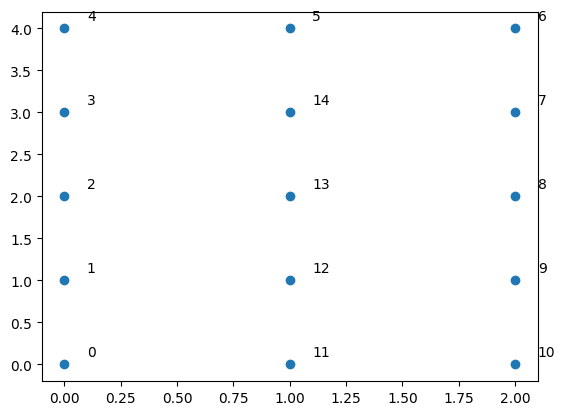

[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 4], [2, 4], [2, 3], [2, 2], [2, 1], [2, 0], [1, 0], [1, 1], [1, 2], [1, 3]]


In [8]:
def spiral_coordinates(n, m):
    # Initialize boundaries
    top, bottom, left, right = 0, n - 1, 0, m - 1
    # Starting point
    i, j = 0, 0
    # Directions: right, down, left, up
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    direction = 0
    result = []

    while top <= bottom and left <= right:
        # Append current coordinate
        result.append((i, j))
        # Move in the current direction
        ni, nj = i + directions[direction][0], j + directions[direction][1]
        
        if direction == 0 and nj > right:
            # Hit the right boundary, go down
            direction = 1
            top += 1
            ni, nj = i + directions[direction][0], j + directions[direction][1]
        elif direction == 1 and ni > bottom:
            # Hit the bottom boundary, go left
            direction = 2
            right -= 1
            ni, nj = i + directions[direction][0], j + directions[direction][1]
        elif direction == 2 and nj < left:
            # Hit the left boundary, go up
            direction = 3
            bottom -= 1
            ni, nj = i + directions[direction][0], j + directions[direction][1]
        elif direction == 3 and ni < top:
            # Hit the top boundary, go right
            direction = 0
            left += 1
            ni, nj = i + directions[direction][0], j + directions[direction][1]

        # Update coordinates
        i, j = ni, nj

    return result

import matplotlib.pyplot as plt
stitch_order = []
plt.figure()
ij_sort = spiral_coordinates(ncol, nrow)
# ij_sort = ij_sort[::-1]
for s, (i, j) in enumerate(ij_sort):
    plt.text(i+0.1, j+0.1, str(s))
    stitch_order.append([i, j])
plt.scatter(np.array(stitch_order)[:, 0], np.array(stitch_order)[:, 1])
plt.show() 
# stitch_order = stitch_order[:-1]
print(stitch_order)
rowwise_order = []
if ncol >= nrow:
    for i in range(ncol):
        for j in range(nrow):
            rowwise_order.append([i, j])
else:
    for j in range(nrow):
        for i in range(ncol):
            rowwise_order.append([i, j])

In [13]:
tile_lt_loc = {
    f'{i}-{j}': [i*seg_shape[1]*(1-overlap_r), j*seg_shape[2]*(1-overlap_r)] for i, j in [[0,0]]+stitch_order
}
tile_lt_loc

{'0-0': [tensor(0.), tensor(0.)],
 '0-1': [tensor(0.), tensor(1605.6000)],
 '0-2': [tensor(0.), tensor(3211.2000)],
 '0-3': [tensor(0.), tensor(4816.8003)],
 '0-4': [tensor(0.), tensor(6422.3999)],
 '1-4': [tensor(1903.2001), tensor(6422.3999)],
 '2-4': [tensor(3806.4001), tensor(6422.3999)],
 '2-3': [tensor(3806.4001), tensor(4816.8003)],
 '2-2': [tensor(3806.4001), tensor(3211.2000)],
 '2-1': [tensor(3806.4001), tensor(1605.6000)],
 '2-0': [tensor(3806.4001), tensor(0.)],
 '1-0': [tensor(1903.2001), tensor(0.)],
 '1-1': [tensor(1903.2001), tensor(1605.6000)],
 '1-2': [tensor(1903.2001), tensor(3211.2000)],
 '1-3': [tensor(1903.2001), tensor(4816.8003)]}

In [409]:
down_r_xy_tile

{'00,00': 5,
 '0-1': 185,
 '0-2': 185,
 '0-3': 170,
 '0-4': 195,
 '1-4': 160,
 '2-4': 100,
 '2-3': 100,
 '2-2': 165,
 '2-1': 165,
 '2-0': 100,
 '1-0': 190,
 '1-1': 360,
 '1-2': 375,
 '1-3': 430}

In [427]:
'''
Coarse reg by spiral order
'''

zrange = zend - zstart
ptreg_min_pt_num = 6000
overlap_r = 0.2
device = 'cuda:3'
gpu_cap_pt_num = 30000
max_iter = 50
base_down_r_xy = 5
base_down_r_z = 1
base_coarse_pt_r = 0.05
down_r_xy = base_down_r_xy
down_r_z = base_down_r_z
i, j = stitch_order[0]
new_tile_pt_coarse = {f'{i}-{j}': outlier_removed_tile_pt[f'{i}-{j}']}
tform_stack_coarse = {f'dz_({i:02d},{j:02d})': [0, 0, 0] for i in range(ncol) for j in range(nrow)}

tformed_tile_lt_loc = {zstart: copy.deepcopy(tile_lt_loc)}

eps = 1
zslice = zstart
for li in range(max_iter):
    iter_treg = []
    for i, j in stitch_order[1 if li == 0 else 0:]:
        '''
        Stitching from scratch by point register NIS center (tile-by-tile)
        '''
        down_r_xy = base_down_r_xy
        down_r_z = base_down_r_z
        coarse_pt_r = base_coarse_pt_r
        while True:
            if li == 0:
                pt_mov_org = outlier_removed_tile_pt[f'{i}-{j}'].clone()
            else:
                pt_mov_org = new_tile_pt_coarse[f'{i}-{j}'].clone()
            pt_mov = pt_mov_org.clone()

            pt_mov_w = seg_shape[1]
            pt_mov_h = seg_shape[2]

            pt_mov_lt_loc = tformed_tile_lt_loc[zslice][f'{i}-{j}']
            pt_tgt = []
            pmask_tgt = []
            mov_pmasks = []
            tgt_tile_id = []
            for pi, pj in neighbor:
                if f'{i+pi}-{j+pj}' in new_tile_pt_coarse:
                    pt_lt_loc = tformed_tile_lt_loc[zslice][f'{i+pi}-{j+pj}']
                    pt = new_tile_pt_coarse[f'{i+pi}-{j+pj}'].clone()
                    tgt_pmasks = []
                    pt_tgt.append(pt)
                    pt_h = seg_shape[2]
                    mov_pmask = []
                    pt_w = seg_shape[1]
                    pt_h = seg_shape[2]
                    if pi < 0:
                        tgt_pmasks.append(pt[:, 1]>=(pt_lt_loc[0]+pt_w*(1-overlap_r)))
                        mov_pmask.append(pt_mov[:, 1]<=(pt_mov_lt_loc[0]+pt_mov_w*(overlap_r)))
                    elif pi > 0:
                        tgt_pmasks.append(pt[:, 1]<=(pt_lt_loc[0]+pt_w*(overlap_r)))
                        mov_pmask.append(pt_mov[:, 1]>=(pt_mov_lt_loc[0]+pt_mov_w*(1-overlap_r)))
                    if pj < 0:
                        tgt_pmasks.append(pt[:, 2]>=(pt_lt_loc[1]+pt_h*(1-overlap_r)))
                        mov_pmask.append(pt_mov[:, 2]<=(pt_mov_lt_loc[1]+pt_mov_h*(overlap_r)))
                    elif pj > 0:
                        tgt_pmasks.append(pt[:, 2]<=(pt_lt_loc[1]+pt_h*(overlap_r)))
                        mov_pmask.append(pt_mov[:, 2]>=(pt_mov_lt_loc[1]+pt_mov_h*(1-overlap_r)))

                    pmask = tgt_pmasks[0]
                    for m in tgt_pmasks[1:]:
                        pmask = torch.logical_and(pmask, m)

                    pmask_tgt.append(pmask)

                    pmask = mov_pmask[0]
                    for m in mov_pmask[1:]:
                        pmask = torch.logical_and(pmask, m)

                    mov_pmasks.append(pmask)
                    tgt_tile_id.append(f'({i+pi:02d},{j+pj:02d})')

            pt_tgt_ = torch.cat(pt_tgt)
            pmask_tgt = torch.cat(pmask_tgt)
            pt_tgt = pt_tgt_[pmask_tgt, :].clone()#.long()
            pmask_mov = mov_pmasks[0]
            for m in mov_pmasks:
                pmask_mov = torch.logical_or(pmask_mov, m)
            pt_mov = pt_mov[pmask_mov, :]

            
    #         # Downsample by randomly sampling points
    #         ## downsample moving points
    #         perm = torch.randperm(pt_mov.shape[0])
    #         pt_mov_id = perm[:int(coarse_pt_r*pt_mov.shape[0])]
    #         pt_mov = pt_mov[pt_mov_id]
    #         ## downsample tgt points
    #         perm = torch.randperm(pt_tgt.shape[0])
    #         pt_tgt_id = perm[:int(coarse_pt_r*pt_tgt.shape[0])]
    #         pt_tgt = pt_tgt[pt_tgt_id]

            # Downsample by merging points
            ## downsample tgt points
            pt_tgt = pt_tgt.to(device)
            pt_tgt[:, 0] = (pt_tgt[:, 0]/down_r_z).long()
            pt_tgt[:, 1:] = (pt_tgt[:, 1:]/down_r_xy).long()
            loc_unique = torch.zeros((pt_tgt.max(0)[0]+1).long().tolist())
            loc_unique[pt_tgt[:, 0].long(), pt_tgt[:, 1].long(), pt_tgt[:, 2].long()] = True
            pt_tgt = torch.stack(torch.where(loc_unique), 1).float() 
            pt_tgt[:, 0] = pt_tgt[:, 0] * down_r_z
            pt_tgt[:, 1:] = pt_tgt[:, 1:] * down_r_xy
            ## downsample moving points
            pt_mov = pt_mov.to(device)
            pt_mov[:, 0] = (pt_mov[:, 0]/down_r_z).long()
            pt_mov[:, 1:] = (pt_mov[:, 1:]/down_r_xy).long()
            loc_unique = torch.zeros((pt_mov.max(0)[0]+1).long().tolist())
            loc_unique[pt_mov[:, 0].long(), pt_mov[:, 1].long(), pt_mov[:, 2].long()] = True
            pt_mov = torch.stack(torch.where(loc_unique), 1).float() 
            pt_mov[:, 0] = pt_mov[:, 0] * down_r_z
            pt_mov[:, 1:] = pt_mov[:, 1:] * down_r_xy

#             pt_mov = get_convex_set(pt_mov)
#             pt_tgt = get_convex_set(pt_tgt)
            
            if pt_mov.shape[0]*pt_tgt.shape[0] > gpu_cap_pt_num**2:
    #             print(datetime.now(), f'Too much points, continue downsampling, moving pt # {pt_mov.shape[0]}, target pt # {pt_tgt.shape[0]}')
                down_r_xy += base_down_r_xy
    #             down_r_z += base_down_r_z
                coarse_pt_r -= 0.001
                continue
            else:
                down_r_xy_tile[f'{i}-{j}'] = down_r_xy
                down_r_z_tile[f'{i}-{j}'] = down_r_z
                print(f'Tile moving ({i:02d},{j:02d})', f'Tile targets {tgt_tile_id}, Downsampled times {(down_r_xy, down_r_z)}')
                print(datetime.now(), f'Point registration from slice {zslice} to {zslice+zrange}, moving pt # {pt_mov.shape[0]}, target pt # {pt_tgt.shape[0]}')
                s_reg, R_reg, t_reg, correspondence = point_reg_cpd(pt_mov, pt_tgt, only_overlap=False, device=device)
                t_reg = t_reg.cpu()
        #                 t_reg[0, 0] = 0
                iter_treg.append(t_reg)
                print(datetime.now(), "Done translation:", t_reg.tolist())
                ## Apply transformation to pt in a tile
                new_tile_pt_coarse[f'{i}-{j}'] = (pt_mov_org + t_reg)#.long()
                tz, tx, ty = t_reg[0].tolist()
#                 tform_stack_coarse[f'dz_({i:02d},{j:02d})'] = [tz, tx, ty]
                tform_stack_coarse[f'dz_({i:02d},{j:02d})'][0] = tform_stack_coarse[f'dz_({i:02d},{j:02d})'][0] + tz
                tform_stack_coarse[f'dz_({i:02d},{j:02d})'][1] = tform_stack_coarse[f'dz_({i:02d},{j:02d})'][1] + tx
                tform_stack_coarse[f'dz_({i:02d},{j:02d})'][2] = tform_stack_coarse[f'dz_({i:02d},{j:02d})'][2] + ty

                tformed_tile_lt_loc[zslice][f'{i}-{j}'][0] = tformed_tile_lt_loc[zslice][f'{i}-{j}'][0] + tx
                tformed_tile_lt_loc[zslice][f'{i}-{j}'][1] = tformed_tile_lt_loc[zslice][f'{i}-{j}'][1] + ty

                torch.cuda.empty_cache()

                break
                
    print("iter", li, tform_stack_coarse)
    if torch.cat(iter_treg)[:, 0].abs().mean() <= eps and li > 0:
        print("stop early since mean(abs(dz))=", torch.cat(iter_treg)[:, 0].abs().mean(), f"<= eps ({eps})")
        break

Tile moving (00,01) Tile targets ['(00,00)'], Downsampled times (185, 1)
2024-07-10 13:45:46.283800 Point registration from slice 0 to 1048, moving pt # 28795, target pt # 29498
2024-07-10 13:45:58.204952 Done translation: [[-2.99200439453125, 0.0, 0.0]]
Tile moving (00,02) Tile targets ['(00,01)'], Downsampled times (185, 1)
2024-07-10 13:45:59.446561 Point registration from slice 0 to 1048, moving pt # 27187, target pt # 29048
2024-07-10 13:46:10.538447 Done translation: [[-7.53125, 0.0001220703125, 0.0]]
Tile moving (00,03) Tile targets ['(00,02)'], Downsampled times (170, 1)
2024-07-10 13:46:12.119654 Point registration from slice 0 to 1048, moving pt # 26638, target pt # 29170
2024-07-10 13:46:22.863209 Done translation: [[-16.246612548828125, 0.0, 0.00048828125]]
Tile moving (00,04) Tile targets ['(00,03)'], Downsampled times (195, 1)
2024-07-10 13:46:24.585635 Point registration from slice 0 to 1048, moving pt # 26829, target pt # 29618
2024-07-10 13:46:35.549826 Done translatio

2024-07-10 13:52:29.078095 Done translation: [[-0.39898681640625, 0.0, 0.00048828125]]
Tile moving (01,02) Tile targets ['(00,02)', '(01,01)', '(00,01)', '(02,02)', '(01,03)', '(02,03)', '(02,01)', '(00,03)'], Downsampled times (435, 1)
2024-07-10 13:52:43.966515 Point registration from slice 0 to 1048, moving pt # 24893, target pt # 24387
2024-07-10 13:52:52.539051 Done translation: [[-0.76922607421875, 0.0, 0.00048828125]]
Tile moving (01,03) Tile targets ['(00,03)', '(01,02)', '(00,02)', '(02,03)', '(01,04)', '(02,04)', '(02,02)', '(00,04)'], Downsampled times (430, 1)
2024-07-10 13:53:07.726800 Point registration from slice 0 to 1048, moving pt # 25502, target pt # 25311
2024-07-10 13:53:16.836220 Done translation: [[0.76434326171875, 0.0, 0.0]]
iter 1 {'dz_(00,00)': [-12.881500244140625, 0.0, 0.0], 'dz_(00,01)': [-15.43560791015625, -0.0001220703125, 0.00048828125], 'dz_(00,02)': [-16.00018310546875, -0.0001220703125, 0.0], 'dz_(00,03)': [-19.154052734375, 0.0, 0.00048828125], 'dz

Tile moving (00,04) Tile targets ['(00,03)', '(01,04)', '(01,03)'], Downsampled times (245, 1)
2024-07-10 13:58:50.614379 Point registration from slice 0 to 1048, moving pt # 27099, target pt # 27146
2024-07-10 13:59:00.808721 Done translation: [[-0.5230712890625, 0.0, 0.0]]
Tile moving (01,04) Tile targets ['(00,04)', '(01,03)', '(00,03)', '(02,04)', '(02,03)'], Downsampled times (255, 1)
2024-07-10 13:59:05.881955 Point registration from slice 0 to 1048, moving pt # 29531, target pt # 30073
2024-07-10 13:59:18.551645 Done translation: [[-0.12994384765625, 0.0, 0.0]]
Tile moving (02,04) Tile targets ['(01,04)', '(02,03)', '(01,03)'], Downsampled times (130, 1)
2024-07-10 13:59:21.684149 Point registration from slice 0 to 1048, moving pt # 28368, target pt # 28775
2024-07-10 13:59:33.289123 Done translation: [[0.5223388671875, -0.00048828125, 0.0]]
Tile moving (02,03) Tile targets ['(01,03)', '(02,02)', '(01,02)', '(02,04)', '(01,04)'], Downsampled times (265, 1)
2024-07-10 13:59:39.43

2024-07-10 14:06:40.150863 Done translation: [[-0.893798828125, 0.0, 0.0]]
Tile moving (01,03) Tile targets ['(00,03)', '(01,02)', '(00,02)', '(02,03)', '(01,04)', '(02,04)', '(02,02)', '(00,04)'], Downsampled times (430, 1)
2024-07-10 14:06:57.998003 Point registration from slice 0 to 1048, moving pt # 25514, target pt # 25303
2024-07-10 14:07:07.328797 Done translation: [[-0.021728515625, 0.000244140625, 0.0]]
iter 4 {'dz_(00,00)': [-21.596038818359375, -0.0001220703125, 0.0001220703125], 'dz_(00,01)': [-23.09368896484375, -0.000244140625, 0.000244140625], 'dz_(00,02)': [-22.097747802734375, -0.0003662109375, 0.0], 'dz_(00,03)': [-22.319305419921875, -0.000244140625, -0.0009765625], 'dz_(00,04)': [-19.403594970703125, 0.0001220703125, 0.0009765625], 'dz_(01,00)': [-6.52227783203125, 0.000732421875, 0.000244140625], 'dz_(01,01)': [-4.31109619140625, 0.00048828125, 0.0], 'dz_(01,02)': [-3.763580322265625, 0.000244140625, 0.0], 'dz_(01,03)': [1.733551025390625, 0.0, -0.00048828125], 'dz

2024-07-10 14:13:53.868570 Done translation: [[0.0404052734375, 0.0, 0.0]]
Tile moving (01,04) Tile targets ['(00,04)', '(01,03)', '(00,03)', '(02,04)', '(02,03)'], Downsampled times (255, 1)
2024-07-10 14:14:00.684735 Point registration from slice 0 to 1048, moving pt # 29531, target pt # 30084
2024-07-10 14:14:13.240176 Done translation: [[0.579833984375, -0.000244140625, -0.00048828125]]
Tile moving (02,04) Tile targets ['(01,04)', '(02,03)', '(01,03)'], Downsampled times (130, 1)
2024-07-10 14:14:16.952387 Point registration from slice 0 to 1048, moving pt # 28310, target pt # 28748
2024-07-10 14:14:28.268504 Done translation: [[-0.0418701171875, 0.00048828125, 0.0]]
Tile moving (02,03) Tile targets ['(01,03)', '(02,02)', '(01,02)', '(02,04)', '(01,04)'], Downsampled times (265, 1)
2024-07-10 14:14:36.813096 Point registration from slice 0 to 1048, moving pt # 28406, target pt # 28978
2024-07-10 14:14:48.394278 Done translation: [[-0.782135009765625, 0.0, 0.0]]
Tile moving (02,02) 

2024-07-10 14:21:55.160810 Done translation: [[-0.662841796875, 0.0, 0.0]]
Tile moving (01,03) Tile targets ['(00,03)', '(01,02)', '(00,02)', '(02,03)', '(01,04)', '(02,04)', '(02,02)', '(00,04)'], Downsampled times (430, 1)
2024-07-10 14:22:06.893221 Point registration from slice 0 to 1048, moving pt # 25519, target pt # 25302
2024-07-10 14:22:15.798215 Done translation: [[-0.2659912109375, 0.0, 0.0]]
iter 7 {'dz_(00,00)': [-24.502838134765625, -0.0001220703125, 0.0001220703125], 'dz_(00,01)': [-26.587677001953125, -0.0001220703125, 0.000244140625], 'dz_(00,02)': [-24.38958740234375, -0.000244140625, 0.00048828125], 'dz_(00,03)': [-23.03271484375, -0.0003662109375, -0.0009765625], 'dz_(00,04)': [-19.04815673828125, 0.0003662109375, 0.00146484375], 'dz_(01,00)': [-9.12274169921875, 0.0009765625, 0.0001220703125], 'dz_(01,01)': [-7.231048583984375, 0.000732421875, 0.0], 'dz_(01,02)': [-5.356353759765625, -0.00048828125, 0.0], 'dz_(01,03)': [1.3946533203125, 0.0, 0.0], 'dz_(01,04)': [-5.

2024-07-10 14:27:38.588372 Done translation: [[-1.016693115234375, 0.0, 0.0]]
Tile moving (01,04) Tile targets ['(00,04)', '(01,03)', '(00,03)', '(02,04)', '(02,03)'], Downsampled times (255, 1)
2024-07-10 14:27:43.571195 Point registration from slice 0 to 1048, moving pt # 29527, target pt # 30085
2024-07-10 14:27:46.778067 Done translation: [[0.901702880859375, 0.0, -0.00048828125]]
Tile moving (02,04) Tile targets ['(01,04)', '(02,03)', '(01,03)'], Downsampled times (130, 1)
2024-07-10 14:27:49.425827 Point registration from slice 0 to 1048, moving pt # 28368, target pt # 28756
2024-07-10 14:28:00.731248 Done translation: [[-0.471466064453125, 0.0, 0.0]]
Tile moving (02,03) Tile targets ['(01,03)', '(02,02)', '(01,02)', '(02,04)', '(01,04)'], Downsampled times (265, 1)
2024-07-10 14:28:06.915364 Point registration from slice 0 to 1048, moving pt # 28406, target pt # 28990
2024-07-10 14:28:18.264259 Done translation: [[-0.487518310546875, 0.0, 0.0]]
Tile moving (02,02) Tile targets [

2024-07-10 14:34:17.441504 Done translation: [[-0.643585205078125, 0.0, 0.0]]
Tile moving (01,03) Tile targets ['(00,03)', '(01,02)', '(00,02)', '(02,03)', '(01,04)', '(02,04)', '(02,02)', '(00,04)'], Downsampled times (430, 1)
2024-07-10 14:34:30.479455 Point registration from slice 0 to 1048, moving pt # 25519, target pt # 25301
2024-07-10 14:34:39.558687 Done translation: [[-0.327178955078125, 0.0, 0.0]]
iter 10 {'dz_(00,00)': [-27.839874267578125, -0.000244140625, 0.000244140625], 'dz_(00,01)': [-28.44537353515625, 0.0, 0.000244140625], 'dz_(00,02)': [-26.249725341796875, -0.000244140625, 0.00048828125], 'dz_(00,03)': [-24.2696533203125, -0.00048828125, -0.00048828125], 'dz_(00,04)': [-20.033172607421875, 0.0003662109375, 0.00146484375], 'dz_(01,00)': [-11.293670654296875, 0.001220703125, 0.0], 'dz_(01,01)': [-9.183013916015625, 0.000244140625, 0.0], 'dz_(01,02)': [-6.59832763671875, -0.000244140625, 0.0], 'dz_(01,03)': [0.747589111328125, 0.00048828125, 0.0], 'dz_(01,04)': [-5.952

2024-07-10 14:40:14.041619 Done translation: [[-0.4969482421875, 0.0, 0.0]]
Tile moving (01,04) Tile targets ['(00,04)', '(01,03)', '(00,03)', '(02,04)', '(02,03)'], Downsampled times (255, 1)
2024-07-10 14:40:18.634955 Point registration from slice 0 to 1048, moving pt # 29527, target pt # 30085
2024-07-10 14:40:23.468484 Done translation: [[0.359405517578125, 0.0, -0.0009765625]]
Tile moving (02,04) Tile targets ['(01,04)', '(02,03)', '(01,03)'], Downsampled times (130, 1)
2024-07-10 14:40:26.221231 Point registration from slice 0 to 1048, moving pt # 28368, target pt # 28757
2024-07-10 14:40:37.897917 Done translation: [[-0.025909423828125, 0.0, 0.0]]
Tile moving (02,03) Tile targets ['(01,03)', '(02,02)', '(01,02)', '(02,04)', '(01,04)'], Downsampled times (265, 1)
2024-07-10 14:40:44.022812 Point registration from slice 0 to 1048, moving pt # 28406, target pt # 28990
2024-07-10 14:40:55.499417 Done translation: [[0.44891357421875, -0.00048828125, 0.0]]
Tile moving (02,02) Tile tar

2024-07-10 14:47:43.532110 Done translation: [[-0.38873291015625, 0.00048828125, -0.000244140625]]
Tile moving (01,03) Tile targets ['(00,03)', '(01,02)', '(00,02)', '(02,03)', '(01,04)', '(02,04)', '(02,02)', '(00,04)'], Downsampled times (430, 1)
2024-07-10 14:48:00.486907 Point registration from slice 0 to 1048, moving pt # 25515, target pt # 25295
2024-07-10 14:48:07.367684 Done translation: [[0.393310546875, 0.0, 0.00048828125]]
iter 13 {'dz_(00,00)': [-28.978607177734375, -0.0003662109375, 0.000244140625], 'dz_(00,01)': [-30.357147216796875, 0.0001220703125, 0.000244140625], 'dz_(00,02)': [-27.31396484375, -0.0001220703125, 0.00048828125], 'dz_(00,03)': [-24.609893798828125, -0.000732421875, -0.0009765625], 'dz_(00,04)': [-20.00860595703125, 0.0003662109375, 0.00146484375], 'dz_(01,00)': [-13.2264404296875, 0.001220703125, 0.0], 'dz_(01,01)': [-10.537017822265625, 0.000244140625, 0.0], 'dz_(01,02)': [-7.248016357421875, 0.000244140625, -0.000732421875], 'dz_(01,03)': [0.945129394

2024-07-10 14:54:40.562476 Done translation: [[-1.01043701171875, 0.0, 0.0]]
Tile moving (01,04) Tile targets ['(00,04)', '(01,03)', '(00,03)', '(02,04)', '(02,03)'], Downsampled times (255, 1)
2024-07-10 14:54:51.912515 Point registration from slice 0 to 1048, moving pt # 29524, target pt # 30088
2024-07-10 14:55:04.598789 Done translation: [[1.00238037109375, -0.000244140625, 0.0]]
Tile moving (02,04) Tile targets ['(01,04)', '(02,03)', '(01,03)'], Downsampled times (130, 1)
2024-07-10 14:55:07.074578 Point registration from slice 0 to 1048, moving pt # 28368, target pt # 28757
2024-07-10 14:55:18.659527 Done translation: [[0.971893310546875, 0.0, 0.0]]
Tile moving (02,03) Tile targets ['(01,03)', '(02,02)', '(01,02)', '(02,04)', '(01,04)'], Downsampled times (265, 1)
2024-07-10 14:55:25.605237 Point registration from slice 0 to 1048, moving pt # 28406, target pt # 28990
2024-07-10 14:55:30.248901 Done translation: [[0.129241943359375, 0.0, -0.00048828125]]
Tile moving (02,02) Tile t

2024-07-10 15:02:58.715916 Done translation: [[-0.197784423828125, 0.0, 0.0]]
Tile moving (01,03) Tile targets ['(00,03)', '(01,02)', '(00,02)', '(02,03)', '(01,04)', '(02,04)', '(02,02)', '(00,04)'], Downsampled times (430, 1)
2024-07-10 15:03:29.256669 Point registration from slice 0 to 1048, moving pt # 25515, target pt # 25293
2024-07-10 15:03:38.754533 Done translation: [[0.147979736328125, 0.0, -0.00048828125]]
iter 16 {'dz_(00,00)': [-31.43829345703125, -0.0003662109375, 0.000244140625], 'dz_(00,01)': [-31.749847412109375, -0.0001220703125, 0.0], 'dz_(00,02)': [-28.85650634765625, 0.0001220703125, 0.0009765625], 'dz_(00,03)': [-24.816680908203125, -0.000732421875, -0.0009765625], 'dz_(00,04)': [-20.7623291015625, 0.0003662109375, 0.00146484375], 'dz_(01,00)': [-14.99688720703125, 0.001220703125, -0.0001220703125], 'dz_(01,01)': [-11.785003662109375, 0.0, -0.000244140625], 'dz_(01,02)': [-7.371063232421875, 0.00048828125, -0.0009765625], 'dz_(01,03)': [0.94158935546875, 0.0021972

2024-07-10 15:10:06.307150 Done translation: [[0.041961669921875, 0.0, 0.0]]
Tile moving (01,04) Tile targets ['(00,04)', '(01,03)', '(00,03)', '(02,04)', '(02,03)'], Downsampled times (255, 1)
2024-07-10 15:10:10.962457 Point registration from slice 0 to 1048, moving pt # 29528, target pt # 30088
2024-07-10 15:10:23.299936 Done translation: [[0.0386962890625, 0.0, 0.0]]
Tile moving (02,04) Tile targets ['(01,04)', '(02,03)', '(01,03)'], Downsampled times (130, 1)
2024-07-10 15:10:26.099932 Point registration from slice 0 to 1048, moving pt # 28368, target pt # 28749
2024-07-10 15:10:37.760101 Done translation: [[0.97723388671875, -0.00048828125, -0.00048828125]]
Tile moving (02,03) Tile targets ['(01,03)', '(02,02)', '(01,02)', '(02,04)', '(01,04)'], Downsampled times (265, 1)
2024-07-10 15:10:46.390469 Point registration from slice 0 to 1048, moving pt # 28406, target pt # 28994
2024-07-10 15:10:49.461364 Done translation: [[0.130645751953125, 0.0, 0.0]]
Tile moving (02,02) Tile targ

KeyboardInterrupt: 

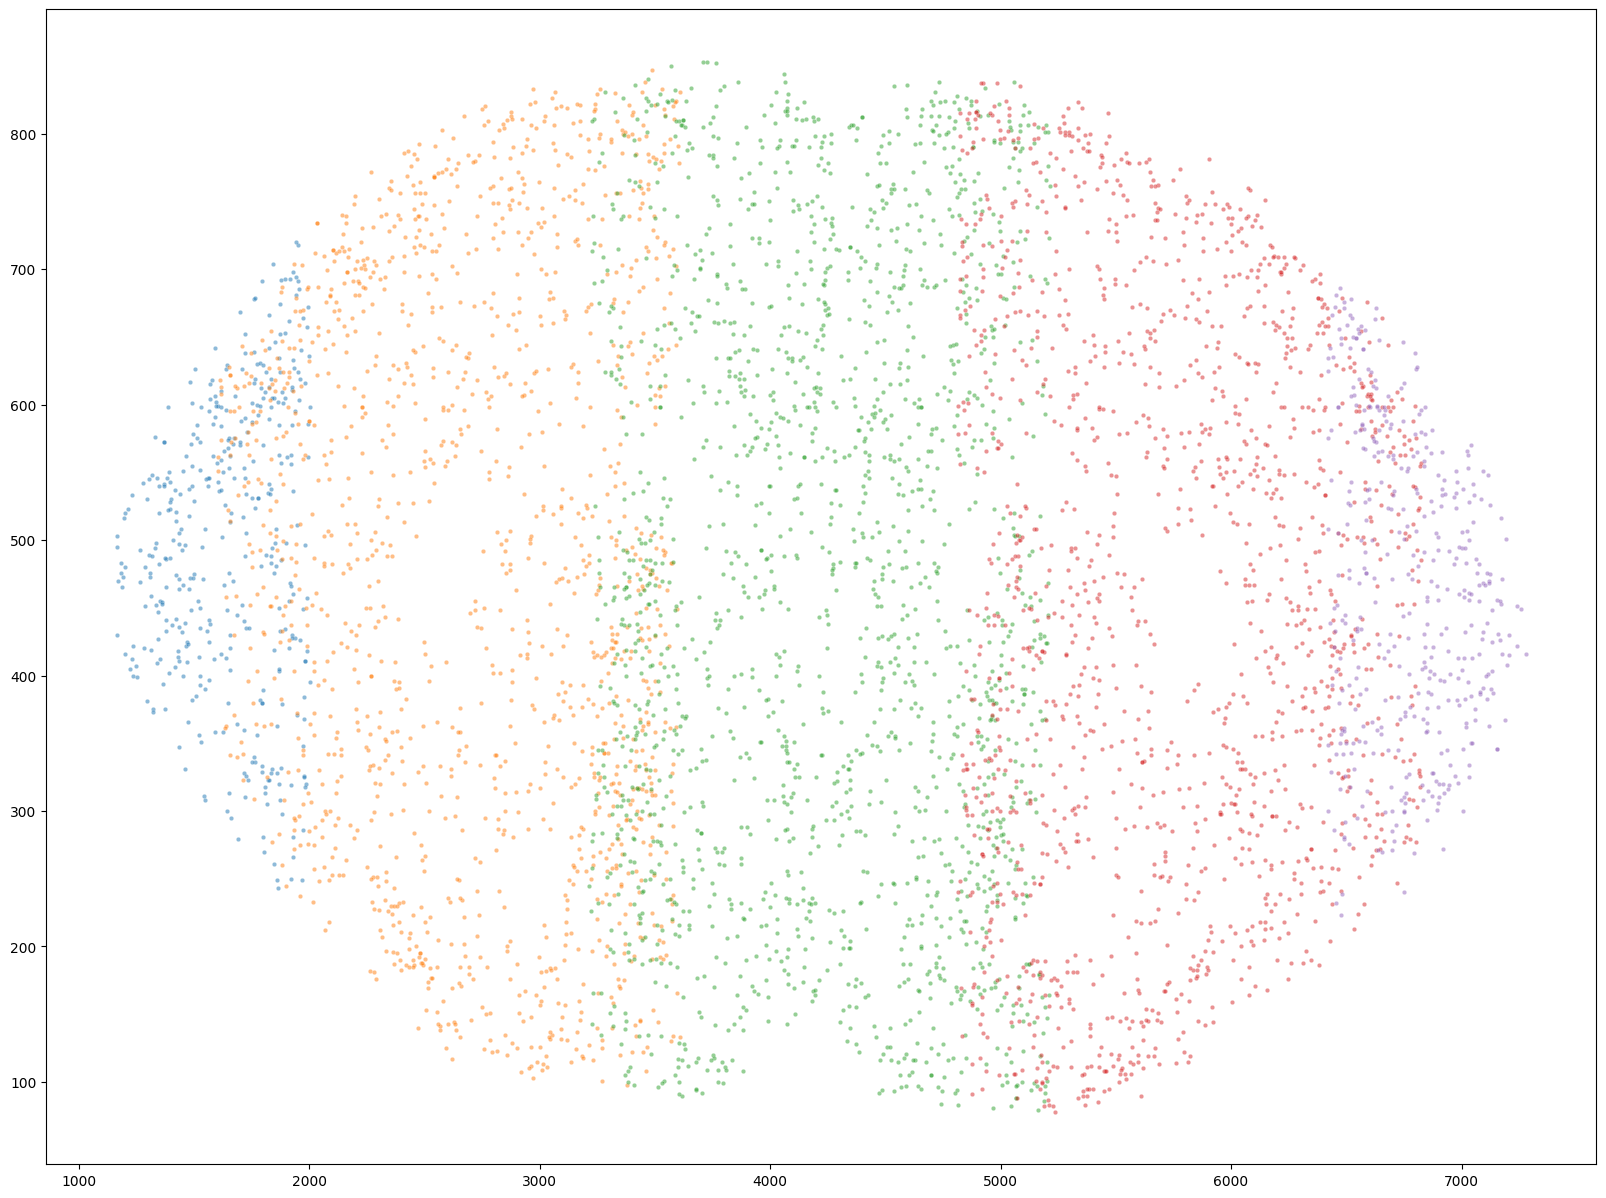

In [441]:
plt.figure(figsize=(20,15))
# for pi, pt in enumerate(new_tile_pt_coarse.values()):
#     pt = pt[pt[:,0].long()==950, 1:]
#     ax = sns.scatterplot(x=pt[:,1], y=pt[:,0], s=10, cmap='tab19', alpha=0.5)
for pi, pt in enumerate(outlier_removed_tile_pt.values()):
    pt = pt[pt[:, 1].long()==4500, :]
    ax = sns.scatterplot(x=pt[:,2], y=pt[:,0], s=10, cmap='tab19', alpha=0.5)

In [416]:
'''
Coarse reg for convex set by spiral order
'''

zrange = zend - zstart
ptreg_min_pt_num = 6000
overlap_r = 0.2
device = 'cuda:2'
gpu_cap_pt_num = 30000

base_down_r_xy = 5
base_down_r_z = 1
base_coarse_pt_r = 0.05
down_r_xy = base_down_r_xy
down_r_z = base_down_r_z
i, j = stitch_order[0]
new_tile_pt_coarse = {f'{i}-{j}': outlier_removed_tile_pt[f'{i}-{j}']}
tform_stack_coarse = {f'dz_({i:02d},{j:02d})': [0, 0, 0] for i in range(ncol) for j in range(nrow)}

tformed_tile_lt_loc = {zstart: copy.deepcopy(tile_lt_loc)}

zslice = zstart
for li in range(2):
    for i, j in stitch_order[1 if li == 0 else 0:]:
        '''
        Stitching from scratch by point register NIS center (tile-by-tile)
        '''
        if li == 0:
            pt_mov_org = outlier_removed_tile_pt[f'{i}-{j}'].clone()
        else:
            pt_mov_org = new_tile_pt_coarse[f'{i}-{j}'].clone()
        pt_mov = pt_mov_org.clone()
        pt_mov = get_convex_set(pt_mov.long().float())

        pt_mov_w = seg_shape[1]
        pt_mov_h = seg_shape[2]

        pt_mov_lt_loc = tformed_tile_lt_loc[zslice][f'{i}-{j}']
        pt_tgt = []
        pmask_tgt = []
        mov_pmasks = []
        tgt_tile_id = []
        for pi, pj in neighbor:
            if f'{i+pi}-{j+pj}' in new_tile_pt_coarse:
                pt_lt_loc = tformed_tile_lt_loc[zslice][f'{i+pi}-{j+pj}']
                pt = new_tile_pt_coarse[f'{i+pi}-{j+pj}'].clone()
                pt = get_convex_set(pt.long().float())
                pt_tgt.append(pt)
                tgt_pmasks = []
                mov_pmask = []
                pt_w = seg_shape[1]
                pt_h = seg_shape[2]
                if pi < 0:
                    tgt_pmasks.append(pt[:, 1]>=(pt_lt_loc[0]+pt_w*(1-overlap_r)))
                    mov_pmask.append(pt_mov[:, 1]<=(pt_mov_lt_loc[0]+pt_mov_w*(overlap_r)))
                elif pi > 0:
                    tgt_pmasks.append(pt[:, 1]<=(pt_lt_loc[0]+pt_w*(overlap_r)))
                    mov_pmask.append(pt_mov[:, 1]>=(pt_mov_lt_loc[0]+pt_mov_w*(1-overlap_r)))
                if pj < 0:
                    tgt_pmasks.append(pt[:, 2]>=(pt_lt_loc[1]+pt_h*(1-overlap_r)))
                    mov_pmask.append(pt_mov[:, 2]<=(pt_mov_lt_loc[1]+pt_mov_h*(overlap_r)))
                elif pj > 0:
                    tgt_pmasks.append(pt[:, 2]<=(pt_lt_loc[1]+pt_h*(overlap_r)))
                    mov_pmask.append(pt_mov[:, 2]>=(pt_mov_lt_loc[1]+pt_mov_h*(1-overlap_r)))

                pmask = tgt_pmasks[0]
                for m in tgt_pmasks[1:]:
                    pmask = torch.logical_and(pmask, m)

                pmask_tgt.append(pmask)

                pmask = mov_pmask[0]
                for m in mov_pmask[1:]:
                    pmask = torch.logical_and(pmask, m)

                mov_pmasks.append(pmask)
                tgt_tile_id.append(f'({i+pi:02d},{j+pj:02d})')

        pt_tgt_ = torch.cat(pt_tgt)
        pmask_tgt = torch.cat(pmask_tgt)
        pt_tgt = pt_tgt_[pmask_tgt, :].clone()#.long()
        pmask_mov = mov_pmasks[0]
        for m in mov_pmasks:
            pmask_mov = torch.logical_or(pmask_mov, m)
        pt_mov = pt_mov[pmask_mov, :]

        print(f'Tile moving ({i:02d},{j:02d})', f'Tile targets {tgt_tile_id}')
        print(datetime.now(), f'Point registration from slice {zslice} to {zslice+zrange}, moving pt # {pt_mov.shape[0]}, target pt # {pt_tgt.shape[0]}')
        s_reg, R_reg, t_reg, correspondence = point_reg_cpd(pt_mov, pt_tgt, only_overlap=False, device=device)
        t_reg = t_reg.cpu()
#         t_reg[0, 1:] = 0
        print(datetime.now(), "Done translation:", t_reg.tolist())
        ## Apply transformation to pt in a tile
        new_tile_pt_coarse[f'{i}-{j}'] = (pt_mov_org + t_reg)#.long()
        tz, tx, ty = t_reg[0].tolist()
        tform_stack_coarse[f'dz_({i:02d},{j:02d})'][0] = tform_stack_coarse[f'dz_({i:02d},{j:02d})'][0] + tz
        tform_stack_coarse[f'dz_({i:02d},{j:02d})'][1] = tform_stack_coarse[f'dz_({i:02d},{j:02d})'][1] + tx
        tform_stack_coarse[f'dz_({i:02d},{j:02d})'][2] = tform_stack_coarse[f'dz_({i:02d},{j:02d})'][2] + ty

        tformed_tile_lt_loc[zslice][f'{i}-{j}'][0] = tformed_tile_lt_loc[zslice][f'{i}-{j}'][0] + tx
        tformed_tile_lt_loc[zslice][f'{i}-{j}'][1] = tformed_tile_lt_loc[zslice][f'{i}-{j}'][1] + ty

        torch.cuda.empty_cache()

#         break

    print(tform_stack_coarse)

Tile moving (00,01) Tile targets ['(00,00)']
2024-07-10 11:32:26.032125 Point registration from slice 0 to 1048, moving pt # 329, target pt # 476
2024-07-10 11:32:26.111403 Done translation: [[14.31207275390625, -39.2969970703125, 236.65966796875]]


KeyboardInterrupt: 

In [428]:
tform_stack_coarse

{'dz_(00,00)': [-31.68572998046875, -0.0003662109375, 0.0001220703125],
 'dz_(00,01)': [-31.924224853515625, -0.0001220703125, 0.0],
 'dz_(00,02)': [-28.47991943359375, 0.0001220703125, 0.000732421875],
 'dz_(00,03)': [-25.143951416015625, -0.00048828125, -0.00048828125],
 'dz_(00,04)': [-20.523223876953125, 0.00048828125, 0.00146484375],
 'dz_(01,00)': [-15.362762451171875, 0.001220703125, -0.0001220703125],
 'dz_(01,01)': [-12.666473388671875, -0.000244140625, -0.000244140625],
 'dz_(01,02)': [-7.68536376953125, 0.00048828125, -0.0009765625],
 'dz_(01,03)': [1.34130859375, 0.002197265625, -0.00146484375],
 'dz_(01,04)': [-6.611175537109375, -0.000244140625, -0.00244140625],
 'dz_(02,00)': [-2.850830078125, 0.00048828125, 0.000732421875],
 'dz_(02,01)': [-5.17706298828125, 0.00048828125, 0.0],
 'dz_(02,02)': [-3.624359130859375, 0.00048828125, 0.000732421875],
 'dz_(02,03)': [0.144256591796875, -0.0009765625, 0.00048828125],
 'dz_(02,04)': [0.574493408203125, 0.0, 0.00048828125]}

In [370]:
'''
Remove outliers from original tile points
'''
outlier_removed_tile_pt = {}
for k in tqdm(org_tile_pt, desc='Remove outliers from original tile points'):
    all_pt = org_tile_pt[k]
    ## outlier removal
    pcd = o3d.pybind.t.geometry.PointCloud()
    pcd.point.positions = o3d.core.Tensor(all_pt.numpy(), device=o3d.core.Device(device.upper()))
    
    _, ind = pcd.to_legacy().remove_statistical_outlier(nb_neighbors=500, std_ratio=3.0)
    outlier_removed_tile_pt[k] = all_pt[ind]
    
    print('pt num prev outlier removel', all_pt.shape[0], 'pt num after outlier removel', len(ind))


Remove outliers from original tile points:   7%|██▋                                      | 1/15 [00:21<04:55, 21.12s/it]

pt num prev outlier removel 2979691 pt num after outlier removel 2837663


Remove outliers from original tile points:  13%|█████▍                                   | 2/15 [00:42<04:35, 21.19s/it]

pt num prev outlier removel 3767956 pt num after outlier removel 3655356


Remove outliers from original tile points:  20%|████████▏                                | 3/15 [01:03<04:12, 21.05s/it]

pt num prev outlier removel 3450317 pt num after outlier removel 3350717


Remove outliers from original tile points:  27%|██████████▉                              | 4/15 [01:26<04:00, 21.82s/it]

pt num prev outlier removel 3942212 pt num after outlier removel 3814718


Remove outliers from original tile points:  33%|█████████████▋                           | 5/15 [01:44<03:25, 20.51s/it]

pt num prev outlier removel 3131902 pt num after outlier removel 2976234


Remove outliers from original tile points:  40%|████████████████▍                        | 6/15 [02:00<02:52, 19.12s/it]

pt num prev outlier removel 2758439 pt num after outlier removel 2629150


Remove outliers from original tile points:  47%|███████████████████▏                     | 7/15 [02:34<03:11, 23.95s/it]

pt num prev outlier removel 5258516 pt num after outlier removel 5164017


Remove outliers from original tile points:  53%|█████████████████████▊                   | 8/15 [03:07<03:08, 26.87s/it]

pt num prev outlier removel 5280648 pt num after outlier removel 5144285


Remove outliers from original tile points:  60%|████████████████████████▌                | 9/15 [03:42<02:55, 29.33s/it]

pt num prev outlier removel 5389014 pt num after outlier removel 5307384


Remove outliers from original tile points:  67%|██████████████████████████▋             | 10/15 [04:00<02:08, 25.69s/it]

pt num prev outlier removel 2855984 pt num after outlier removel 2736889


Remove outliers from original tile points:  73%|█████████████████████████████▎          | 11/15 [04:03<01:15, 18.78s/it]

pt num prev outlier removel 604156 pt num after outlier removel 575288


Remove outliers from original tile points:  80%|████████████████████████████████        | 12/15 [04:22<00:56, 18.97s/it]

pt num prev outlier removel 3226017 pt num after outlier removel 3100808


Remove outliers from original tile points:  87%|██████████████████████████████████▋     | 13/15 [04:46<00:41, 20.55s/it]

pt num prev outlier removel 3982363 pt num after outlier removel 3833308


Remove outliers from original tile points:  93%|█████████████████████████████████████▎  | 14/15 [05:05<00:19, 19.93s/it]

pt num prev outlier removel 3122459 pt num after outlier removel 2990912


Remove outliers from original tile points: 100%|████████████████████████████████████████| 15/15 [05:08<00:00, 20.55s/it]

pt num prev outlier removel 601749 pt num after outlier removel 571513


torch.Size([5389014, 3]) torch.Size([2855984, 3])
tensor([1048, 4281, 6822]) tensor([ 906, 4281, 8258])
[tensor(1903.2001), tensor(4816.8003)] [tensor(1903.2001), tensor(6422.3999)]
5389014
5371064
2855984
2823680


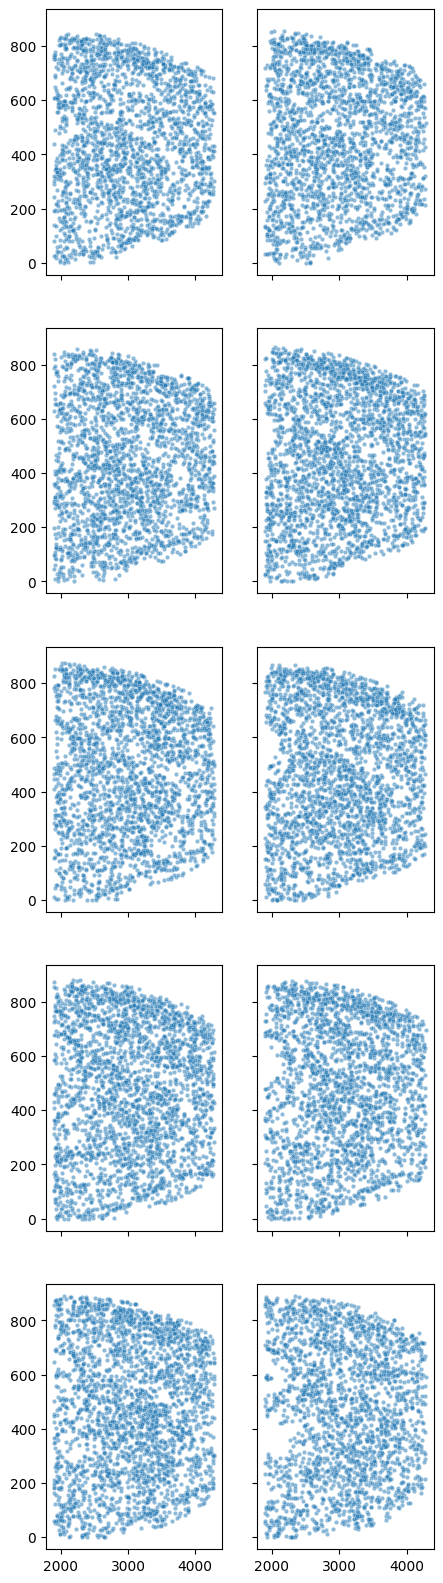

In [415]:
tile1 = '1-3'
tile2 = '1-4'
overlap_dim = 2 # 1 or 2
plot_dim = 1 if overlap_dim == 2 else 2
print(org_tile_pt[tile1].shape, org_tile_pt[tile2].shape)
print(org_tile_pt[tile1].max(0)[0], org_tile_pt[tile2].max(0)[0])
print(tile_lt_loc[tile1], tile_lt_loc[tile2])

fig, axes = plt.subplots(5, 2, figsize=(5,20), sharey=True, sharex=True)
ai = 0
all_pt1 =  org_tile_pt[tile1]
pcd1 = o3d.pybind.t.geometry.PointCloud()
pcd1.point.positions = o3d.core.Tensor(all_pt1.numpy(), device=o3d.core.Device(device.upper()))
_, ind1 = pcd1.to_legacy().remove_statistical_outlier(nb_neighbors=500, std_ratio=3.0)
print(all_pt1.shape[0])
print(len(ind1))
all_pt2 =  org_tile_pt[tile2]
pcd2 = o3d.pybind.t.geometry.PointCloud()
pcd2.point.positions = o3d.core.Tensor(all_pt2.numpy(), device=o3d.core.Device(device.upper()))
_, ind2 = pcd2.to_legacy().remove_statistical_outlier(nb_neighbors=500, std_ratio=3.0)
print(all_pt2.shape[0])
print(len(ind2))
for r in range(1, 21, 4):
    ## outlier removal
    loc1 = (tile_lt_loc[tile1][overlap_dim-1]+seg_shape[overlap_dim]*(1-r/100)).long()
#     pt1 = all_pt1[all_pt1[:, overlap_dim].long() == loc1]
    _pt2 = all_pt2[ind2][all_pt2[ind2, overlap_dim].long() == loc1]
    _pt1 = all_pt1[ind1][all_pt1[ind1, overlap_dim].long() == loc1]
    #############
    ## before / after outlier removal
#     sns.scatterplot(x=pt1[:,plot_dim], y=pt1[:,0], s=10, cmap='tab19', alpha=0.5, ax=axes[ai, 0])
    sns.scatterplot(x=_pt1[:,plot_dim], y=_pt1[:,0], s=10, cmap='tab19', alpha=0.5, ax=axes[ai, 0])
    sns.scatterplot(x=_pt2[:,plot_dim], y=_pt2[:,0], s=10, cmap='tab19', alpha=0.5, ax=axes[ai, 1])
    ai += 1
plt.show()

torch.Size([5389014, 3]) torch.Size([2855984, 3])
tensor([1048, 4281, 6822]) tensor([ 906, 4281, 8258])
[tensor(1903.2001), tensor(4816.8003)] [tensor(1903.2001), tensor(6422.3999)]
tensor(4258) tensor(4258) torch.Size([6074, 3]) torch.Size([7492, 3])
tensor(4163) tensor(4163) torch.Size([6919, 3]) torch.Size([7684, 3])
tensor(4068) tensor(4068) torch.Size([7968, 3]) torch.Size([7865, 3])
tensor(3972) tensor(3972) torch.Size([8245, 3]) torch.Size([7668, 3])
tensor(3877) tensor(3877) torch.Size([8668, 3]) torch.Size([6840, 3])


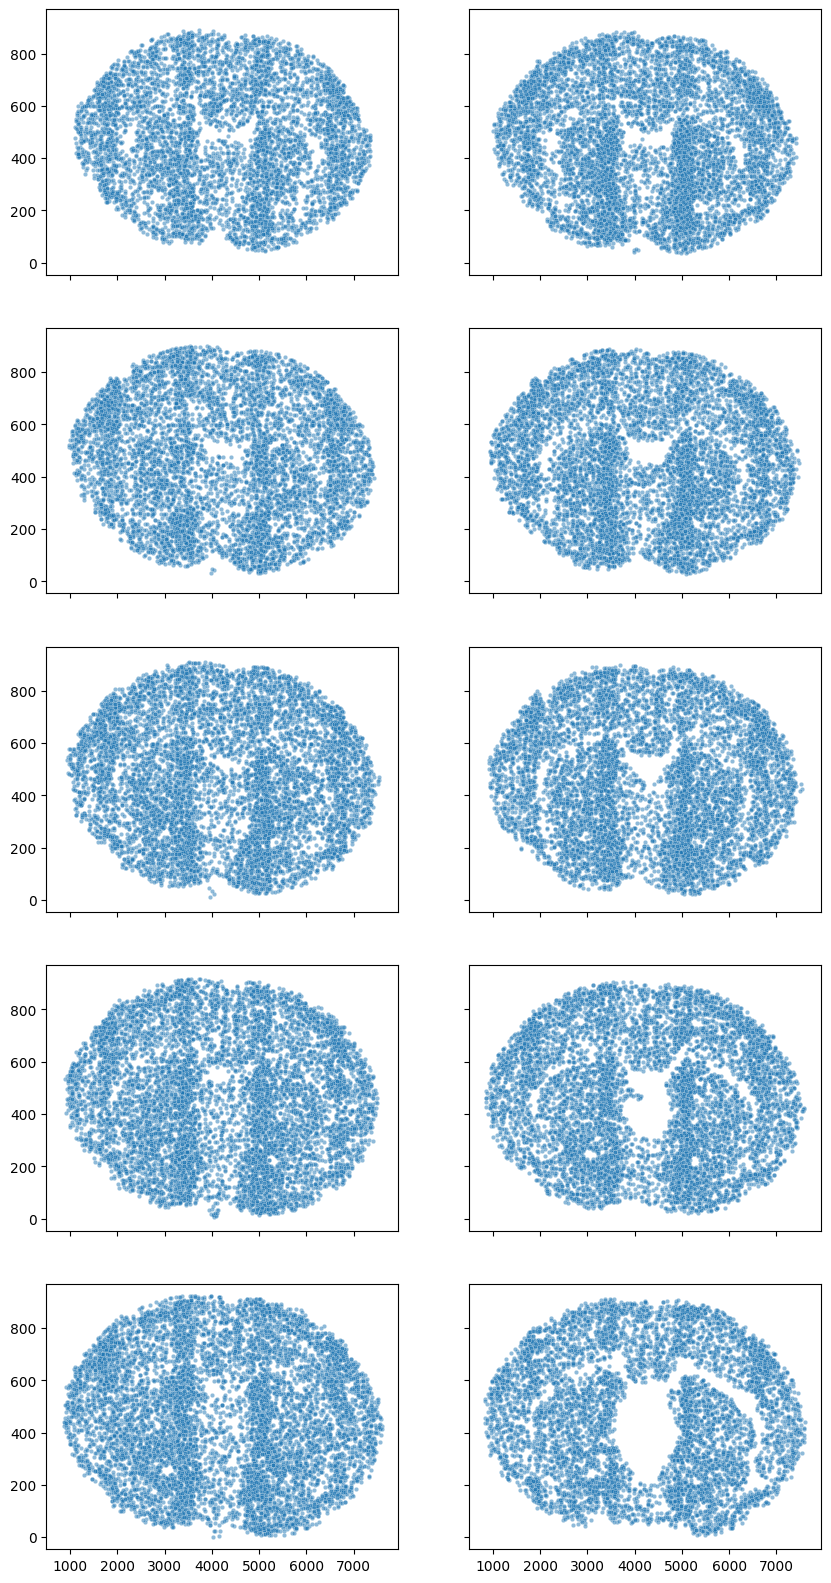

In [373]:
tile1 = '1-3'
tile2 = '1-4'
overlap_dim = 1 # 1 or 2
plot_dim = 1 if overlap_dim == 2 else 2
print(org_tile_pt[tile1].shape, org_tile_pt[tile2].shape)
print(org_tile_pt[tile1].max(0)[0], org_tile_pt[tile2].max(0)[0])
print(tile_lt_loc[tile1], tile_lt_loc[tile2])

fig, axes = plt.subplots(5, 2, figsize=(10,20), sharey=True, sharex=True)
ai = 0
for r in range(1, 21, 4):
    ## one tile
#     loc1 = (tile_lt_loc[tile1][overlap_dim-1]+seg_shape[overlap_dim]*(1-r/100)).long()
#     loc2 = (tile_lt_loc[tile2][overlap_dim-1]+seg_shape[overlap_dim]*(overlap_r-r/100)).long()
#     pt1 = all_pt1[all_pt1[:, overlap_dim].long() == loc1]
#     pt2 = all_pt2[all_pt2[:, overlap_dim].long() == loc1]
    ## one row
    pt1 = []
    pt2 = []
    for j in range(nrow):
        tile1 = f'1-{j}'
        tile2 = f'2-{j}'
        loc1 = (tile_lt_loc[tile1][overlap_dim-1]+seg_shape[overlap_dim]*(1-r/100)).long()
        loc2 = (tile_lt_loc[tile2][overlap_dim-1]+seg_shape[overlap_dim]*(overlap_r-r/100)).long()
        ppt1 = outlier_removed_tile_pt[tile1][outlier_removed_tile_pt[tile1][:, overlap_dim].long() == loc1]
        ppt2 = outlier_removed_tile_pt[tile2][outlier_removed_tile_pt[tile2][:, overlap_dim].long() == loc1]
        pt1.append(ppt1)
        pt2.append(ppt2)
    pt1 = torch.cat(pt1)
    pt2 = torch.cat(pt2)
    #############
    if pt1.shape[0] == 0: break
    print(loc1, loc2, pt1.shape, pt2.shape)
    sns.scatterplot(x=pt1[:,plot_dim], y=pt1[:,0], s=10, cmap='tab19', alpha=0.5, ax=axes[ai, 0])
    sns.scatterplot(x=pt2[:,plot_dim], y=pt2[:,0], s=10, cmap='tab19', alpha=0.5, ax=axes[ai, 1])
    ai += 1
plt.show()

torch.Size([5389014, 3]) torch.Size([2855984, 3])
tensor([1048, 4281, 6822]) tensor([ 906, 4281, 8258])
[tensor(1903.2001), tensor(4816.8003)] [tensor(1903.2001), tensor(6422.3999)]
tensor(2355) tensor(2355) torch.Size([7621, 3]) torch.Size([9031, 3])
tensor(2260) tensor(2260) torch.Size([8522, 3]) torch.Size([8914, 3])
tensor(2164) tensor(2164) torch.Size([8465, 3]) torch.Size([8580, 3])
tensor(2069) tensor(2069) torch.Size([8815, 3]) torch.Size([8494, 3])
tensor(1974) tensor(1974) torch.Size([8628, 3]) torch.Size([8429, 3])


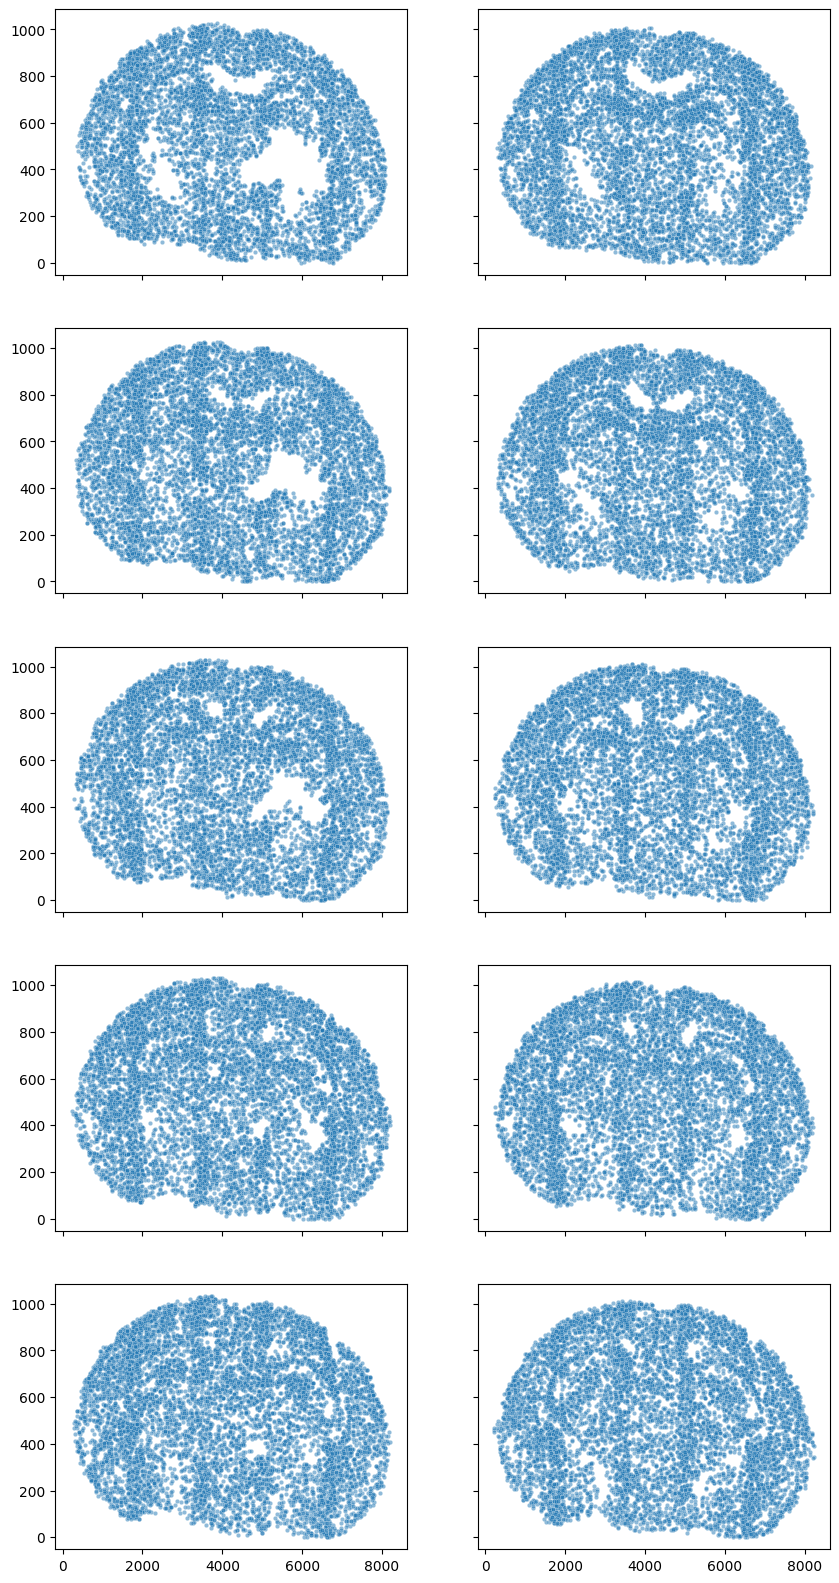

In [312]:
tile1 = '1-3'
tile2 = '1-4'
overlap_dim = 1 # 1 or 2
plot_dim = 1 if overlap_dim == 2 else 2
print(org_tile_pt[tile1].shape, org_tile_pt[tile2].shape)
print(org_tile_pt[tile1].max(0)[0], org_tile_pt[tile2].max(0)[0])
print(tile_lt_loc[tile1], tile_lt_loc[tile2])

fig, axes = plt.subplots(5, 2, figsize=(10,20), sharey=True, sharex=True)
ai = 0
for r in range(1, 21, 4):
    ## one tile
#     loc1 = (tile_lt_loc[tile1][overlap_dim-1]+seg_shape[overlap_dim]*(1-r/100)).long()
#     loc2 = (tile_lt_loc[tile2][overlap_dim-1]+seg_shape[overlap_dim]*(overlap_r-r/100)).long()
#     pt1 = all_pt1[all_pt1[:, overlap_dim].long() == loc1]
#     pt2 = all_pt2[all_pt2[:, overlap_dim].long() == loc1]
    ## one row
    pt1 = []
    pt2 = []
    for j in range(nrow):
        tile1 = f'0-{j}'
        tile2 = f'1-{j}'
        loc1 = (tile_lt_loc[tile1][overlap_dim-1]+seg_shape[overlap_dim]*(1-r/100)).long()
        loc2 = (tile_lt_loc[tile2][overlap_dim-1]+seg_shape[overlap_dim]*(overlap_r-r/100)).long()
        ppt1 = outlier_removed_tile_pt[tile1][outlier_removed_tile_pt[tile1][:, overlap_dim].long() == loc1]
        ppt2 = outlier_removed_tile_pt[tile2][outlier_removed_tile_pt[tile2][:, overlap_dim].long() == loc1]
        pt1.append(ppt1)
        pt2.append(ppt2)
    pt1 = torch.cat(pt1)
    pt2 = torch.cat(pt2)
    #############
    if pt1.shape[0] == 0: break
    print(loc1, loc2, pt1.shape, pt2.shape)
    sns.scatterplot(x=pt1[:,plot_dim], y=pt1[:,0], s=10, cmap='tab19', alpha=0.5, ax=axes[ai, 0])
    sns.scatterplot(x=pt2[:,plot_dim], y=pt2[:,0], s=10, cmap='tab19', alpha=0.5, ax=axes[ai, 1])
    ai += 1
plt.show()

In [89]:
row_order = [nrow//2] + [(-1)**i*(i//2+1)+nrow//2 for i in range(nrow-1)]
for i in range(nrow): 
    if i not in row_order: row_order.append(i)
col_order = [ncol//2] + [(-1)**i*(i//2+1)+ncol//2 for i in range(ncol-1)]
for i in range(ncol): 
    if i not in col_order: col_order.append(i)

print(col_order, row_order)


[1, 2, 0] [2, 3, 1, 4, 0]


In [353]:
def get_convex_set(pt):
    pcd = o3d.pybind.t.geometry.PointCloud()
    pcd.point.positions = o3d.core.Tensor(pt.numpy())
    hull = pcd.compute_convex_hull()
    return torch.from_numpy(np.asarray(hull.to_legacy().vertices))

In [351]:
import open3d as o3d
convex_set = {}
base_down_r_xy = 5
base_down_r_z = 1
base_coarse_pt_r = 0.05
whole_brain_pt = []
for i in range(ncol):
    for j in range(nrow):
        pt = outlier_removed_tile_pt[f'{i}-{j}'].float()
        pcd = o3d.pybind.t.geometry.PointCloud()
        pcd.point.positions = o3d.core.Tensor(pt.numpy())
        hull = pcd.compute_convex_hull()
        convex_set[f'{i}-{j}'] = torch.from_numpy(np.asarray(hull.to_legacy().vertices))
        print(i, j, pt.shape, convex_set[f'{i}-{j}'].shape)                
  

0 0 torch.Size([2837663, 3]) torch.Size([1305, 3])
0 1 torch.Size([3655356, 3]) torch.Size([765, 3])
0 2 torch.Size([3350717, 3]) torch.Size([730, 3])
0 3 torch.Size([3814718, 3]) torch.Size([825, 3])
0 4 torch.Size([2976234, 3]) torch.Size([1518, 3])
1 0 torch.Size([2629150, 3]) torch.Size([909, 3])
1 1 torch.Size([5164017, 3]) torch.Size([659, 3])
1 2 torch.Size([5144285, 3]) torch.Size([532, 3])
1 3 torch.Size([5307384, 3]) torch.Size([846, 3])
1 4 torch.Size([2736889, 3]) torch.Size([932, 3])
2 0 torch.Size([575288, 3]) torch.Size([476, 3])
2 1 torch.Size([3100808, 3]) torch.Size([838, 3])
2 2 torch.Size([1987075, 3]) torch.Size([481, 3])
2 3 torch.Size([2990912, 3]) torch.Size([738, 3])
2 4 torch.Size([571513, 3]) torch.Size([523, 3])


/ram/USERS/ziquanw/softwares/miniconda3/envs/wholeBrain/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



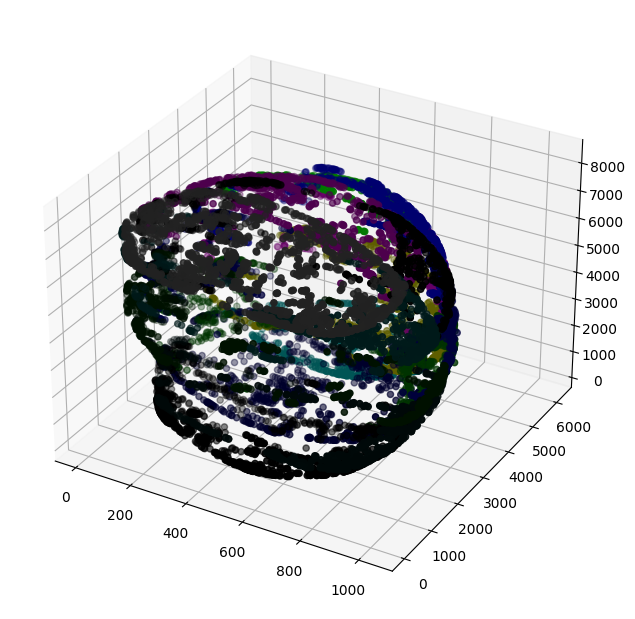

In [352]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6))

ax = Axes3D(fig)

for ki, k in enumerate(convex_set):
    pt = convex_set[k]
    ax.scatter(pt[:,0], pt[:,1], pt[:,2], color=[ki/(len(convex_set)*2) if torch.randn(1)>0.5 else 0 for i in range(3)])


In [363]:
zstart=0

In [365]:
'''
Coarse reg for points in convex set and row-first
'''

zrange = zend - zstart
ptreg_min_pt_num = 6000
overlap_r = 0.2
device = 'cuda:3'
gpu_cap_pt_num = 30000

j = row_order[0]
new_tile_pt_coarse = {f'{i}-{j}': outlier_removed_tile_pt[f'{i}-{j}'] for i in range(ncol)}
tform_stack_coarse = {f'dz_({i:02d},{j:02d})': [0, 0, 0] for i in range(ncol)}
tformed_tile_lt_loc = {zstart: copy.deepcopy(tile_lt_loc)}

neighbor_row = [[0, -1], [0, 1]]
neighbor_col = [[-1, 0], [1, 0]]

zslice = zstart
for i in range(ncol):
# for i in col_order:
    for j in row_order[1:]:
        '''
        Stitching from scratch by point register NIS center (tile-by-tile)
        '''
        pt_mov_org = outlier_removed_tile_pt[f'{i}-{j}'].clone()
        pt_mov = pt_mov_org.clone()
        pt_mov = get_convex_set(pt_mov)

        pt_mov_h = seg_shape[2]

        pt_mov_lt_loc = tformed_tile_lt_loc[zslice][f'{i}-{j}']
        pt_tgt = []
        pmask_tgt = []
        mov_pmasks = []
        tgt_tile_id = []
        for pi, pj in neighbor_row:
            if f'{i+pi}-{j+pj}' in new_tile_pt_coarse:
                pt_lt_loc = tformed_tile_lt_loc[zslice][f'{i+pi}-{j+pj}']
                pt = new_tile_pt_coarse[f'{i+pi}-{j+pj}'].clone()
                pt = get_convex_set(pt)
                tgt_pmasks = []
                pt_tgt.append(pt)
                pt_h = seg_shape[2]
                mov_pmask = []
                if pj < 0:
                    pmask_tgt.append(pt[:, 2]>=(pt_lt_loc[1]+pt_h*(1-overlap_r)))
                    mov_pmasks.append(pt_mov[:, 2]<=(pt_mov_lt_loc[1]+pt_mov_h*(overlap_r)))
                elif pj > 0:
                    pmask_tgt.append(pt[:, 2]<=(pt_lt_loc[1]+pt_h*(overlap_r)))
                    mov_pmasks.append(pt_mov[:, 2]>=(pt_mov_lt_loc[1]+pt_mov_h*(1-overlap_r)))

                tgt_tile_id.append(f'({i+pi:02d},{j+pj:02d})')

        pt_tgt_ = torch.cat(pt_tgt)
        pmask_tgt = torch.cat(pmask_tgt)
        pt_tgt = pt_tgt_[pmask_tgt, :].clone()#.long()
        pmask_mov = mov_pmasks[0]
        for m in mov_pmasks:
            pmask_mov = torch.logical_or(pmask_mov, m)
        pt_mov = pt_mov[pmask_mov, :]
            
        print(f'Tile moving ({i:02d},{j:02d})', f'Tile targets {tgt_tile_id}')
        print(datetime.now(), f'Point registration from slice {zslice} to {zslice+zrange}, moving pt # {pt_mov.shape[0]}, target pt # {pt_tgt.shape[0]}')
        s_reg, R_reg, t_reg, correspondence = point_reg_cpd(pt_mov, pt_tgt, only_overlap=False, device=device)
        t_reg = t_reg.cpu()
        t_reg[0, 1:] = 0
        print(datetime.now(), "Done translation:", t_reg.tolist())
        ## Apply transformation to pt in a tile
        new_tile_pt_coarse[f'{i}-{j}'] = (pt_mov_org + t_reg)#.long()
        tz, tx, ty = t_reg[0].tolist()
        tform_stack_coarse[f'dz_({i:02d},{j:02d})'] = [tz, tx, ty]

        tformed_tile_lt_loc[zslice][f'{i}-{j}'][0] = tformed_tile_lt_loc[zslice][f'{i}-{j}'][0] + tx
        tformed_tile_lt_loc[zslice][f'{i}-{j}'][1] = tformed_tile_lt_loc[zslice][f'{i}-{j}'][1] + ty

        torch.cuda.empty_cache()


    if i == 0: continue

    pt_mov_org = torch.cat([new_tile_pt_coarse[f'{i}-{jj}'].clone() for jj in row_order])    
    pt_mov = pt_mov_org.clone()
    pt_mov = get_convex_set(pt_mov)
    pt_mov_w = seg_shape[1]

    pt_tgt = []
    pmask_tgt = []
    mov_pmasks = []
    tgt_tile_id = []
    pt_mov_lt_loc = tformed_tile_lt_loc[zslice][f'{i}-{j}']

    for pi, pj in neighbor_col:
        if f'{i+pi}-{j+pj}' in new_tile_pt_coarse:
            pt = torch.cat([new_tile_pt_coarse[f'{i+pi}-{jj}'].clone() for jj in row_order])
            pt = get_convex_set(pt)
            pt_lt_loc = tformed_tile_lt_loc[zslice][f'{i+pi}-{j+pj}']
            pt_tgt.append(pt)
            pt_w = seg_shape[1]
            tgt_pmasks = []
            mov_pmask = []
            if pi < 0:
                pmask_tgt.append(pt[:, 1]>=(pt_lt_loc[0]+pt_w*(1-overlap_r)))
                mov_pmasks.append(pt_mov[:, 1]<=(pt_mov_lt_loc[0]+pt_mov_w*(overlap_r)))
            elif pi > 0:
                pmask_tgt.append(pt[:, 1]<=(pt_lt_loc[0]+pt_w*(overlap_r)))
                mov_pmasks.append(pt_mov[:, 1]>=(pt_mov_lt_loc[0]+pt_mov_w*(1-overlap_r)))

            tgt_tile_id.append(f'({i+pi:02d},:)')

    pt_tgt_ = torch.cat(pt_tgt)
    pmask_tgt = torch.cat(pmask_tgt)
    pt_tgt = pt_tgt_[pmask_tgt, :].clone()#.long()
    pmask_mov = mov_pmasks[0]
    for m in mov_pmasks:
        pmask_mov = torch.logical_or(pmask_mov, m)
    pt_mov = pt_mov[pmask_mov, :]

    print(f'Tile moving ({i:02d},:)', f'Tile targets {tgt_tile_id}')
    print(datetime.now(), f'Point registration from slice {zslice} to {zslice+zrange}, moving pt # {pt_mov.shape[0]}, target pt # {pt_tgt.shape[0]}')
    s_reg, R_reg, t_reg, correspondence = point_reg_cpd(pt_mov, pt_tgt, only_overlap=False, device=device)
    t_reg = t_reg.cpu()
    t_reg[0, 1:] = 0
    print(datetime.now(), "Done translation:", t_reg.tolist())
    ## Apply transformation to pt in a tile
    for jj in row_order:
        new_tile_pt_coarse[f'{i}-{jj}'] = (new_tile_pt_coarse[f'{i}-{jj}'] + t_reg)#.long()

        tz, tx, ty = t_reg[0].tolist()

        tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][0] = tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][0] + tz
        tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][1] = tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][1] + tx
        tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][2] = tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][2] + ty

        tformed_tile_lt_loc[zslice][f'{i}-{jj}'][0] = tformed_tile_lt_loc[zslice][f'{i}-{jj}'][0] + tx
        tformed_tile_lt_loc[zslice][f'{i}-{jj}'][1] = tformed_tile_lt_loc[zslice][f'{i}-{jj}'][1] + ty

    torch.cuda.empty_cache()

            
tform_stack_coarse   


Tile moving (00,03) Tile targets ['(00,02)'], Downsampled times (50, 10)
2024-07-09 18:05:07.118084 Point registration from slice 0 to 1048, moving pt # 244, target pt # 286
2024-07-09 18:05:07.253642 Done translation: [[-18.805328369140625, 0.0, 0.0]]
Tile moving (00,01) Tile targets ['(00,02)'], Downsampled times (50, 10)
2024-07-09 18:05:09.080153 Point registration from slice 0 to 1048, moving pt # 266, target pt # 263
2024-07-09 18:05:09.110612 Done translation: [[12.58355712890625, 0.0, 0.0]]
Tile moving (00,04) Tile targets ['(00,03)'], Downsampled times (50, 10)
2024-07-09 18:05:10.120856 Point registration from slice 0 to 1048, moving pt # 548, target pt # 392
2024-07-09 18:05:10.167825 Done translation: [[-24.86859130859375, 0.0, 0.0]]
Tile moving (00,00) Tile targets ['(00,01)'], Downsampled times (50, 10)
2024-07-09 18:05:11.217278 Point registration from slice 0 to 1048, moving pt # 476, target pt # 329
2024-07-09 18:05:11.247126 Done translation: [[2.04937744140625, 0.0, 

{'dz_(00,02)': [0, 0, 0],
 'dz_(01,02)': [32.22076416015625, 0.0, 0.0],
 'dz_(02,02)': [-46.50103759765625, 0.0, 0.0],
 'dz_(00,03)': [-18.805328369140625, 0.0, 0.0],
 'dz_(00,01)': [12.58355712890625, 0.0, 0.0],
 'dz_(00,04)': [-24.86859130859375, 0.0, 0.0],
 'dz_(00,00)': [2.04937744140625, 0.0, 0.0],
 'dz_(01,03)': [22.672576904296875, 0.0, 0.0],
 'dz_(01,01)': [26.2515869140625, 0.0, 0.0],
 'dz_(01,04)': [8.1876220703125, 0.0, 0.0],
 'dz_(01,00)': [20.857879638671875, 0.0, 0.0],
 'dz_(02,03)': [-42.604095458984375, 0.0, 0.0],
 'dz_(02,01)': [-29.926513671875, 0.0, 0.0],
 'dz_(02,04)': [-29.08709716796875, 0.0, 0.0],
 'dz_(02,00)': [-63.92376708984375, 0.0, 0.0]}

In [204]:
tile_lt_loc

{'0-0': [tensor(0.), tensor(0.)],
 '0-1': [tensor(0.), tensor(1605.6000)],
 '0-2': [tensor(0.), tensor(3211.2000)],
 '0-3': [tensor(0.), tensor(4816.8003)],
 '0-4': [tensor(0.), tensor(6422.3999)],
 '1-4': [tensor(1903.2001), tensor(6422.3999)],
 '2-4': [tensor(3806.4001), tensor(6422.3999)],
 '2-3': [tensor(3806.4001), tensor(4816.8003)],
 '2-2': [tensor(3806.4001), tensor(3211.2000)],
 '2-1': [tensor(3806.4001), tensor(1605.6000)],
 '2-0': [tensor(3806.4001), tensor(0.)],
 '1-0': [tensor(1903.2001), tensor(0.)],
 '1-1': [tensor(1903.2001), tensor(1605.6000)],
 '1-2': [tensor(1903.2001), tensor(3211.2000)],
 '1-3': [tensor(1903.2001), tensor(4816.8003)]}

In [319]:
'''
Coarse reg by reducing precision of point coordinates and row-first
'''

zrange = zend - zstart
ptreg_min_pt_num = 6000
overlap_r = 0.2
device = 'cuda:3'
gpu_cap_pt_num = 30000

base_down_r_xy = 5
base_down_r_z = 1
base_coarse_pt_r = 0.05
down_r_xy = base_down_r_xy
down_r_z = base_down_r_z
j = row_order[0]
new_tile_pt_coarse = {f'{i}-{j}': outlier_removed_tile_pt[f'{i}-{j}'] for i in range(ncol)}
tform_stack_coarse = {f'dz_({i:02d},{j:02d})': [0, 0, 0] for i in range(ncol)}

tformed_tile_lt_loc = {zstart: copy.deepcopy(tile_lt_loc)}

neighbor_row = [[0, -1], [0, 1]]
neighbor_col = [[-1, 0], [1, 0]]

zslice = zstart
for i in range(ncol):
# for i in col_order:
    for j in row_order[1:]:
        '''
        Stitching from scratch by point register NIS center (tile-by-tile)
        '''
        down_r_xy = base_down_r_xy
        down_r_z = base_down_r_z
        coarse_pt_r = base_coarse_pt_r
        while True:
            pt_mov_org = outlier_removed_tile_pt[f'{i}-{j}'].clone()
            pt_mov = pt_mov_org.clone()

            pt_mov_h = seg_shape[2]

            pt_mov_lt_loc = tformed_tile_lt_loc[zslice][f'{i}-{j}']
            pt_tgt = []
            pmask_tgt = []
            mov_pmasks = []
            tgt_tile_id = []
            for pi, pj in neighbor_row:
                if f'{i+pi}-{j+pj}' in new_tile_pt_coarse:
                    pt_lt_loc = tformed_tile_lt_loc[zslice][f'{i+pi}-{j+pj}']
                    pt = new_tile_pt_coarse[f'{i+pi}-{j+pj}'].clone()
                    tgt_pmasks = []
                    pt_tgt.append(pt)
                    pt_h = seg_shape[2]
                    mov_pmask = []
                    if pj < 0:
                        pmask_tgt.append(pt[:, 2]>=(pt_lt_loc[1]+pt_h*(1-overlap_r)))
                        mov_pmasks.append(pt_mov[:, 2]<=(pt_mov_lt_loc[1]+pt_mov_h*(overlap_r)))
                    elif pj > 0:
                        pmask_tgt.append(pt[:, 2]<=(pt_lt_loc[1]+pt_h*(overlap_r)))
                        mov_pmasks.append(pt_mov[:, 2]>=(pt_mov_lt_loc[1]+pt_mov_h*(1-overlap_r)))

                    tgt_tile_id.append(f'({i+pi:02d},{j+pj:02d})')

            pt_tgt_ = torch.cat(pt_tgt)
            pmask_tgt = torch.cat(pmask_tgt)
            pt_tgt = pt_tgt_[pmask_tgt, :].clone()#.long()
            pmask_mov = mov_pmasks[0]
            for m in mov_pmasks:
                pmask_mov = torch.logical_or(pmask_mov, m)
            pt_mov = pt_mov[pmask_mov, :]
            
            # Downsample by randomly sampling points
            ## downsample moving points
            perm = torch.randperm(pt_mov.shape[0])
            pt_mov_id = perm[:int(coarse_pt_r*pt_mov.shape[0])]
            pt_mov = pt_mov[pt_mov_id]
            ## downsample tgt points
            perm = torch.randperm(pt_tgt.shape[0])
            pt_tgt_id = perm[:int(coarse_pt_r*pt_tgt.shape[0])]
            pt_tgt = pt_tgt[pt_tgt_id]
            
#             # Downsample by merging points
#             ## downsample tgt points
#             pt_tgt[:, 0] = (pt_tgt[:, 0]/down_r_z).long()
#             pt_tgt[:, 1:] = (pt_tgt[:, 1:]/down_r_xy).long()
#             loc_unique = torch.zeros((pt_tgt.max(0)[0]+1).long().tolist())
#             loc_unique[pt_tgt[:, 0].long(), pt_tgt[:, 1].long(), pt_tgt[:, 2].long()] = True
#             pt_tgt = torch.stack(torch.where(loc_unique), 1).float() 
#             pt_tgt[:, 0] = pt_tgt[:, 0] * down_r_z
#             pt_tgt[:, 1:] = pt_tgt[:, 1:] * down_r_xy
#             ## downsample moving points
#             pt_mov[:, 0] = (pt_mov[:, 0]/down_r_z).long()
#             pt_mov[:, 1:] = (pt_mov[:, 1:]/down_r_xy).long()
#             loc_unique = torch.zeros((pt_mov.max(0)[0]+1).long().tolist())
#             loc_unique[pt_mov[:, 0].long(), pt_mov[:, 1].long(), pt_mov[:, 2].long()] = True
#             pt_mov = torch.stack(torch.where(loc_unique), 1).float() 
#             pt_mov[:, 0] = pt_mov[:, 0] * down_r_z
#             pt_mov[:, 1:] = pt_mov[:, 1:] * down_r_xy

            if pt_mov.shape[0]*pt_tgt.shape[0] > gpu_cap_pt_num**2:
    #             print(datetime.now(), f'Too much points, continue downsampling, moving pt # {pt_mov.shape[0]}, target pt # {pt_tgt.shape[0]}')
                down_r_xy += base_down_r_xy
                down_r_z += base_down_r_z
                coarse_pt_r -= 0.001
                continue
            else:
                print(f'Tile moving ({i:02d},{j:02d})', f'Tile targets {tgt_tile_id}, Downsampled times {(down_r_xy, down_r_z)}')
                print(datetime.now(), f'Point registration from slice {zslice} to {zslice+zrange}, moving pt # {pt_mov.shape[0]}, target pt # {pt_tgt.shape[0]}')
                s_reg, R_reg, t_reg, correspondence = point_reg_cpd(pt_mov, pt_tgt, only_overlap=False, device=device)
                t_reg = t_reg.cpu()
#                 t_reg[0, 0] = 0
                print(datetime.now(), "Done translation:", t_reg.tolist())
                ## Apply transformation to pt in a tile
                new_tile_pt_coarse[f'{i}-{j}'] = (pt_mov_org + t_reg)#.long()
                tz, tx, ty = t_reg[0].tolist()
                tform_stack_coarse[f'dz_({i:02d},{j:02d})'] = [tz, tx, ty]

                tformed_tile_lt_loc[zslice][f'{i}-{j}'][0] = tformed_tile_lt_loc[zslice][f'{i}-{j}'][0] + tx
                tformed_tile_lt_loc[zslice][f'{i}-{j}'][1] = tformed_tile_lt_loc[zslice][f'{i}-{j}'][1] + ty

                torch.cuda.empty_cache()

                break

    if i == 0: continue
    down_r_xy = base_down_r_xy
    down_r_z = base_down_r_z
    coarse_pt_r = base_coarse_pt_r
    while True:
        pt_mov_org = torch.cat([new_tile_pt_coarse[f'{i}-{jj}'].clone() for jj in row_order])    
        pt_mov = pt_mov_org.clone()
        pt_mov_w = seg_shape[1]

        pt_tgt = []
        pmask_tgt = []
        mov_pmasks = []
        tgt_tile_id = []
        pt_mov_lt_loc = tformed_tile_lt_loc[zslice][f'{i}-{j}']
        
        for pi, pj in neighbor_col:
            if f'{i+pi}-{j+pj}' in new_tile_pt_coarse:
                pt = torch.cat([new_tile_pt_coarse[f'{i+pi}-{jj}'].clone() for jj in row_order])
                pt_lt_loc = tformed_tile_lt_loc[zslice][f'{i+pi}-{j+pj}']
                pt_tgt.append(pt)
                pt_w = seg_shape[1]
                tgt_pmasks = []
                mov_pmask = []
                if pi < 0:
                    pmask_tgt.append(pt[:, 1]>=(pt_lt_loc[0]+pt_w*(1-overlap_r)))
                    mov_pmasks.append(pt_mov[:, 1]<=(pt_mov_lt_loc[0]+pt_mov_w*(overlap_r)))
                elif pi > 0:
                    pmask_tgt.append(pt[:, 1]<=(pt_lt_loc[0]+pt_w*(overlap_r)))
                    mov_pmasks.append(pt_mov[:, 1]>=(pt_mov_lt_loc[0]+pt_mov_w*(1-overlap_r)))

                tgt_tile_id.append(f'({i+pi:02d},:)')

        pt_tgt_ = torch.cat(pt_tgt)
        pmask_tgt = torch.cat(pmask_tgt)
        pt_tgt = pt_tgt_[pmask_tgt, :].clone()#.long()
        pmask_mov = mov_pmasks[0]
        for m in mov_pmasks:
            pmask_mov = torch.logical_or(pmask_mov, m)
        pt_mov = pt_mov[pmask_mov, :]
                    
        # Downsample by randomly sampling points
        ## downsample moving points
        perm = torch.randperm(pt_mov.shape[0])
        pt_mov_id = perm[:int(coarse_pt_r*pt_mov.shape[0])]
        pt_mov = pt_mov[pt_mov_id]
        ## downsample tgt points
        perm = torch.randperm(pt_tgt.shape[0])
        pt_tgt_id = perm[:int(coarse_pt_r*pt_tgt.shape[0])]
        pt_tgt = pt_tgt[pt_tgt_id]
        
#         # Downsample by merging points
#         ## downsample tgt points
#         pt_tgt[:, 0] = (pt_tgt[:, 0]/down_r_z).long()
#         pt_tgt[:, 1:] = (pt_tgt[:, 1:]/down_r_xy).long()
#         loc_unique = torch.zeros((pt_tgt.max(0)[0]+1).long().tolist())
#         loc_unique[pt_tgt[:, 0].long(), pt_tgt[:, 1].long(), pt_tgt[:, 2].long()] = True
#         pt_tgt = torch.stack(torch.where(loc_unique), 1).float() 
#         pt_tgt[:, 0] = pt_tgt[:, 0] * down_r_z
#         pt_tgt[:, 1:] = pt_tgt[:, 1:] * down_r_xy
#         ## downsample moving points
#         pt_mov[:, 0] = (pt_mov[:, 0]/down_r_z).long()
#         pt_mov[:, 1:] = (pt_mov[:, 1:]/down_r_xy).long()
#         loc_unique = torch.zeros((pt_mov.max(0)[0]+1).long().tolist())
#         loc_unique[pt_mov[:, 0].long(), pt_mov[:, 1].long(), pt_mov[:, 2].long()] = True
#         pt_mov = torch.stack(torch.where(loc_unique), 1).float() 
#         pt_mov[:, 0] = pt_mov[:, 0] * down_r_z
#         pt_mov[:, 1:] = pt_mov[:, 1:] * down_r_xy

        if pt_mov.shape[0]*pt_tgt.shape[0] > gpu_cap_pt_num**2:
#             print(pt_mov.shape[0], pt_tgt.shape[0], coarse_pt_r)
            down_r_xy += base_down_r_xy
            down_r_z += base_down_r_z
            coarse_pt_r -= 0.001
            continue
        else:
            print(f'Tile moving ({i:02d},:)', f'Tile targets {tgt_tile_id}, Downsampled times {(down_r_xy, down_r_z)}')
            print(datetime.now(), f'Point registration from slice {zslice} to {zslice+zrange}, moving pt # {pt_mov.shape[0]}, target pt # {pt_tgt.shape[0]}')
            s_reg, R_reg, t_reg, correspondence = point_reg_cpd(pt_mov, pt_tgt, only_overlap=False, device=device)
            t_reg = t_reg.cpu()
#             t_reg[0,0] = 0
            print(datetime.now(), "Done translation:", t_reg.tolist())
            ## Apply transformation to pt in a tile
            for jj in row_order:
                new_tile_pt_coarse[f'{i}-{jj}'] = (new_tile_pt_coarse[f'{i}-{jj}'] + t_reg)#.long()

                tz, tx, ty = t_reg[0].tolist()
                
                tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][0] = tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][0] + tz
                tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][1] = tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][1] + tx
                tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][2] = tform_stack_coarse[f'dz_({i:02d},{jj:02d})'][2] + ty

                tformed_tile_lt_loc[zslice][f'{i}-{jj}'][0] = tformed_tile_lt_loc[zslice][f'{i}-{jj}'][0] + tx
                tformed_tile_lt_loc[zslice][f'{i}-{jj}'][1] = tformed_tile_lt_loc[zslice][f'{i}-{jj}'][1] + ty

            torch.cuda.empty_cache()

            break
            
tform_stack_coarse   


# tformed_tile_lt_loc = {0: tformed_tile_lt_loc[0]}
# for zi in range(zstart+1, zend):
#     tformed_tile_lt_loc[zi] = tformed_tile_lt_loc[0]

Tile moving (00,03) Tile targets ['(00,02)'], Downsampled times (5, 1)
2024-07-09 17:14:06.311854 Point registration from slice 598 to 1048, moving pt # 25914, target pt # 30163
2024-07-09 17:14:13.032831 Done translation: [[-20.11553955078125, -10.2659912109375, -20.986328125]]
Tile moving (00,01) Tile targets ['(00,02)'], Downsampled times (20, 4)
2024-07-09 17:14:13.367424 Point registration from slice 598 to 1048, moving pt # 32900, target pt # 26428
2024-07-09 17:14:25.665515 Done translation: [[-1.30706787109375, 1.6119384765625, 6.835693359375]]
Tile moving (00,04) Tile targets ['(00,03)'], Downsampled times (95, 19)
2024-07-09 17:14:27.298527 Point registration from slice 598 to 1048, moving pt # 27917, target pt # 31722
2024-07-09 17:14:39.617126 Done translation: [[-25.20361328125, -11.233642578125, -29.22314453125]]
Tile moving (00,00) Tile targets ['(00,01)'], Downsampled times (75, 15)
2024-07-09 17:14:40.772126 Point registration from slice 598 to 1048, moving pt # 31872,

{'dz_(00,02)': [0, 0, 0],
 'dz_(01,02)': [3.793701171875, -1.44140625, -9.24560546875],
 'dz_(02,02)': [9.99542236328125, -9.21728515625, -3.31884765625],
 'dz_(00,03)': [-20.11553955078125, -10.2659912109375, -20.986328125],
 'dz_(00,01)': [-1.30706787109375, 1.6119384765625, 6.835693359375],
 'dz_(00,04)': [-25.20361328125, -11.233642578125, -29.22314453125],
 'dz_(00,00)': [-1.3575439453125, 10.1427001953125, 12.5283203125],
 'dz_(01,03)': [3.28131103515625, -5.436767578125, -15.34326171875],
 'dz_(01,01)': [1.4105224609375, -4.572021484375, -2.84228515625],
 'dz_(01,04)': [0.200531005859375, -9.890869140625, -21.6142578125],
 'dz_(01,00)': [-2.558868408203125, -1.888427734375, 1.921875],
 'dz_(02,03)': [5.96820068359375, -10.16796875, -18.341796875],
 'dz_(02,01)': [9.656890869140625, -18.7744140625, 6.975341796875],
 'dz_(02,04)': [3.515838623046875, -8.43017578125, -23.26904296875],
 'dz_(02,00)': [9.6429443359375, -14.28173828125, 10.8231201171875]}

<function open3d.cuda.pybind.pipelines.registration.PyCapsule.registration_icp>

In [195]:
for k in new_tile_pt_coarse:
    print(k, new_tile_pt_coarse[k].shape, new_tile_pt_coarse[k].max(0)[0], new_tile_pt_coarse[k].min(0)[0])

0-0 torch.Size([2979691, 3]) tensor([ 967, 2378, 2006]) tensor([  0,   0, 158])
0-1 torch.Size([3767956, 3]) tensor([1038.9963, 2378.0000, 3611.0000]) tensor([-3.6621e-03,  0.0000e+00,  1.6050e+03])
0-2 torch.Size([3450317, 3]) tensor([1036., 2378., 5217.]) tensor([   0.,  181., 3211.])
0-3 torch.Size([3942212, 3]) tensor([ 996.1440, 2378.0000, 6822.0005]) tensor([  -9.8560,    0.0000, 4816.0005])
0-4 torch.Size([3131902, 3]) tensor([ 907.9628, 2378.0000, 8274.0000]) tensor([ -11.0372,    0.0000, 6422.0000])
1-4 torch.Size([2855984, 3]) tensor([ 905.7893, 4281.0000, 8258.0000]) tensor([-2.1072e-01,  1.9030e+03,  6.4220e+03])
2-4 torch.Size([601749, 3]) tensor([ 800.2247, 5497.0000, 7667.0000]) tensor([  72.2248, 3806.0000, 6422.0000])
2-3 torch.Size([3122459, 3]) tensor([ 910.1545, 6184.0000, 6821.9990]) tensor([3.1545e+00, 3.8060e+03, 4.8160e+03])
2-2 torch.Size([2055293, 3]) tensor([ 916.7467, 6173.2495, 5231.0737]) tensor([-3.2533e+00,  3.7952e+03,  3.2251e+03])
2-1 torch.Size([3226

In [128]:
tformed_tile_lt_loc[0]

{'0-0': [tensor(0.), tensor(0.)],
 '0-1': [tensor(0.), tensor(1605.6002)],
 '0-2': [tensor(0.), tensor(3211.2000)],
 '0-3': [tensor(0.), tensor(4816.8008)],
 '0-4': [tensor(0.), tensor(6422.3999)],
 '1-4': [tensor(1915.8073), tensor(6430.2158)],
 '2-4': [tensor(3810.4438), tensor(6435.0391)],
 '2-3': [tensor(3810.4438), tensor(4829.4404)],
 '2-2': [tensor(3810.4438), tensor(3223.8391)],
 '2-1': [tensor(3810.4434), tensor(1618.2391)],
 '2-0': [tensor(3810.4443), tensor(12.6392)],
 '1-0': [tensor(1916.7213), tensor(-7.9031)],
 '1-1': [tensor(1903.2001), tensor(1605.6000)],
 '1-2': [tensor(1903.2001), tensor(3211.1995)],
 '1-3': [tensor(1903.2001), tensor(4816.7998)]}

In [126]:
{'0-0': [tensor(0.), tensor(0.)],
 '0-1': [tensor(0.), tensor(1605.6002)],
 '0-2': [tensor(0.), tensor(3211.2000)],
 '0-3': [tensor(0.), tensor(4816.8008)],
 '0-4': [tensor(0.), tensor(6422.3999)],
 '1-4': [tensor(1915.8073), tensor(6430.2158)],
 '2-4': [tensor(3810.4438), tensor(6435.0391)],
 '2-3': [tensor(3810.4438), tensor(4829.4404)],
 '2-2': [tensor(3810.4438), tensor(3223.8391)],
 '2-1': [tensor(3810.4434), tensor(1618.2391)],
 '2-0': [tensor(3810.4443), tensor(12.6392)],
 '1-0': [tensor(1916.7213), tensor(-7.9031)],
 '1-1': [tensor(1903.2001), tensor(1605.6000)],
 '1-2': [tensor(1903.2001), tensor(3211.1995)],
 '1-3': [tensor(1903.2001), tensor(4816.7998)]}

NameError: name 'tensor' is not defined

In [360]:
tformed_tile_lt_loc.keys()

dict_keys([598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795,

In [421]:
corse_tformed_tile_lt_loc = copy.deepcopy(tformed_tile_lt_loc)

In [422]:
tformed_tile_lt_loc = {zi: copy.deepcopy(corse_tformed_tile_lt_loc[zstart]) for zi in range(zstart, zend)}
tform_stack_refine = {zi: copy.deepcopy(tform_stack_coarse) for zi in range(zstart, zend)}

In [446]:
tform_stack_coarse_colrow = {'0-0': [[0], [0], [0]], '0-1': [[-1.0], [-5.0], [0.0]], '0-2': [[2.0], [-5.0], [0.0]], '0-3': [[3.0], [0.0], [-8.0]], '0-4': [[1.0], [6.0], [-8.0]], '1-0': [[0, 26.0], [0, 0.0], [0, 20.0]], '1-1': [[3.0, 22.0], [-6.0, -5.0], [0.0, 52.0]], '1-2': [[5.0, 16.0], [-2.0, -5.0], [0.0, 32.0]], '1-3': [[5.0, 8.0], [2.0, 17.0], [-10.0, 78.0]], '1-4': [[3.0, 0.0], [7.0, 12.0], [-14.0, 49.0]], '2-0': [[0, 29.0], [0, 0.0], [0, 26.0]], '2-1': [[1.0, 22.5], [-5.0, -5.5], [0.0, 26.0]], '2-2': [[1.0, 17.5], [-4.0, -3.5], [-12.0, 40.0]], '2-3': [[0.0, 7.5], [-4.0, -9.5], [-25.0, 34.0]], '2-4': [[-1.0, -0.5], [0.0, 2.5], [-37.0, 38.5]]}

In [472]:
tform_stack_coarse = json.load(open(f'{save_path}/NIS_tranform/{stack_name.replace("instance_center.zip", "tform_coarse.json")}', 'r', encoding='utf-8'))

tform_stack_coarse

{'0-0': [0.0, 0.0, 0.0],
 '0-1': [0.0, -6.0, 0.0],
 '0-2': [2.0, -2.0, -10.0],
 '0-3': [4.0, 4.0, -16.0],
 '0-4': [2.0, 10.0, -16.0],
 '1-0': [26.0, 0.0, 18.0],
 '1-1': [22.0, -6.0, 52.0],
 '1-2': [14.0, 4.0, 28.0],
 '1-3': [10.0, 20.0, 70.0],
 '1-4': [0.0, 16.0, 42.0],
 '2-0': [42.0, 0.0, 34.0],
 '2-1': [36.0, 2.0, 74.0],
 '2-2': [20.0, 4.0, 52.0],
 '2-3': [12.0, 26.0, 114.0],
 '2-4': [-2.0, 8.0, 64.0]}

In [508]:
'''
Refine reg 
'''
device = 'cuda:3'
zrange = ZRANGE
i, j = stitch_order[0]
new_tile_pt_refine = {f'{i}-{j}': new_tile_pt_coarse[f'{i}-{j}']}
# tform_stack = {
#     f'Z{int(zstart):04d}:Z{int(zend):04d}_({i:02d},{j:02d})': [0, 0],
#     f'dz_({i:02d},{j:02d})': [[0, f'Z{int(zstart):04d}:Z{int(zend):04d}']]
# }
# tformed_tile_lt_loc[zstart]
# tformed_tile_lt_loc = {zi: copy.deepcopy(tile_lt_loc) for zi in range(zstart, zend)}
tformed_tile_lt_loc = {zi: copy.deepcopy(corse_tformed_tile_lt_loc[zstart]) for zi in range(zstart, zend)}
tform_stack_refine = {zi: copy.deepcopy(tform_stack_coarse) for zi in range(zstart, zend)}

overlap_r = OVERLAP_R
ptreg_min_pt_num = 50
gpu_cap_pt_num = 30000
for i, j in stitch_order[1:]:
#     print(f'Tile loc ({i:02d},{j:02d})')
    '''
    Stitching from scratch by point register NIS center (tile-by-tile)
    '''
    pt_mov_tile = new_tile_pt_coarse[f'{i}-{j}'].clone()
#     zslice = zstart
#     while zslice < zend:

    zslice = zend-1
    while zslice > 0:
#         zup = zslice-zstart
#         zdown = zslice+zrange-zstart
        zup = max(zstart, zslice - zrange)
        zdown = zslice
        if zdown <= 900: break
        m1 = pt_mov_tile[:, 0].long()>=zup
        m2 = pt_mov_tile[:, 0].long()<zdown
        pt_mov_zmask = torch.where(torch.logical_and(m1, m2))[0]      
        pt_mov = pt_mov_tile[pt_mov_zmask, :].clone()

        pt_mov_w = seg_shape[1]
        pt_mov_h = seg_shape[2]
            
        pt_mov_lt_loc = tformed_tile_lt_loc[zslice][f'{i}-{j}']
        pt_tgt = []
        pmask_tgt = []
        mov_pmasks = []
        tgt_tile_id = []
        for pi, pj in neighbor:
            if f'{i+pi}-{j+pj}' in new_tile_pt_refine:
                pt_lt_loc = tformed_tile_lt_loc[zslice][f'{i+pi}-{j+pj}']
                pt = new_tile_pt_refine[f'{i+pi}-{j+pj}']
                pt_zmask = torch.where(torch.logical_and(pt[:, 0].long()>=zup, pt[:, 0].long()<zdown))[0]      
                pt = pt[pt_zmask, :]
                tgt_pmasks = []
                if pt.shape[0] > 0:
                    mov_pmask = []
                    pt_tgt.append(pt)
                    pt_w = seg_shape[1]
                    pt_h = seg_shape[2]
                    if pi < 0:
                        tgt_pmasks.append(pt[:, 1]>=(pt_lt_loc[0]+pt_w*(1-overlap_r)))
                        mov_pmask.append(pt_mov[:, 1]<=(pt_mov_lt_loc[0]+pt_mov_w*(overlap_r)))
                    elif pi > 0:
                        tgt_pmasks.append(pt[:, 1]<=(pt_lt_loc[0]+pt_w*(overlap_r)))
                        mov_pmask.append(pt_mov[:, 1]>=(pt_mov_lt_loc[0]+pt_mov_w*(1-overlap_r)))
                    if pj < 0:
                        tgt_pmasks.append(pt[:, 2]>=(pt_lt_loc[1]+pt_h*(1-overlap_r)))
                        mov_pmask.append(pt_mov[:, 2]<=(pt_mov_lt_loc[1]+pt_mov_h*(overlap_r)))
                    elif pj > 0:
                        tgt_pmasks.append(pt[:, 2]<=(pt_lt_loc[1]+pt_h*(overlap_r)))
                        mov_pmask.append(pt_mov[:, 2]>=(pt_mov_lt_loc[1]+pt_mov_h*(1-overlap_r)))

                    pmask = tgt_pmasks[0]
                    for m in tgt_pmasks[1:]:
                        pmask = torch.logical_and(pmask, m)

                    pmask_tgt.append(pmask)
                    
                    pmask = mov_pmask[0]
                    for m in mov_pmask[1:]:
                        pmask = torch.logical_and(pmask, m)

                    mov_pmasks.append(pmask)
                    
                    tgt_tile_id.append(f'{i+pi}-{j+pj}')
                
        if len(pmask_tgt) > 0:
            pt_tgt_ = torch.cat(pt_tgt)
            pmask_tgt = torch.cat(pmask_tgt)
            pt_tgt = pt_tgt_[pmask_tgt, :].clone()
            
            pmask_mov = mov_pmasks[0]
            for m in mov_pmasks:
                pmask_mov = torch.logical_or(pmask_mov, m)
            pt_mov = pt_mov[pmask_mov, :]
            
        else:
            pt_tgt = pt_tgt_ = torch.zeros(0, 3)

    
        if (pt_mov.shape[0] < ptreg_min_pt_num or pt_tgt.shape[0] < ptreg_min_pt_num) and pt_mov.shape[0]*pt_tgt.shape[0] < gpu_cap_pt_num**2 and zup > 0:
            # and zslice + zrange < zend: 
            zrange = zrange + ZRANGE
            continue
        else:
            if pt_mov.shape[0] > 0 and pt_tgt.shape[0] > 0:
                print(f'Tile moving ({i:02d},{j:02d})', f'Tile targets {tgt_tile_id}')
                print(datetime.now(), f'Point registration from slice {zup} to {zdown}, moving pt # {pt_mov.shape[0]}, target pt # {pt_tgt.shape[0]}')
                s_reg, R_reg, t_reg, correspondence = point_reg_cpd(pt_mov, pt_tgt, only_overlap=False, device=device)
                t_reg = t_reg.cpu()
    #             t_reg[0,0] = 0
                print(datetime.now(), "Done translation:", t_reg.tolist())
                ## Apply transformation to pt in a tile
            else:
                t_reg = torch.zeros(1, 3)
                
            pt = pt_mov_tile[pt_mov_zmask, :].clone()
#                 pt = pt + t_reg
            pt[:, 1:] = pt[:, 1:] + t_reg[:, 1:]
            if pt_mov.shape[0] > 0 and pt_tgt.shape[0] > 0:
                ## Remove matched points
                min_dis = distance_mat(pt.to(device), pt_tgt_.to(device)).cpu()
                mov_matched_index = torch.where(min_dis<=10)[0]
                ###########################################################
                mask = torch.ones(pt.shape[0]).bool()
                mask[mov_matched_index] = False
                pt = pt[mask]
            if f'{i}-{j}' not in new_tile_pt_refine: 
                new_tile_pt_refine[f'{i}-{j}'] = pt
            else:
                new_tile_pt_refine[f'{i}-{j}'] = torch.cat([new_tile_pt_refine[f'{i}-{j}'], pt])
                    
            tz, tx, ty = t_reg[0].tolist()
#             tform_stack[f'Z{zslice:04d}:Z{zslice+zrange:04d}_({i:02d},{j:02d})'] = [tx, ty]
#             tz = tform_stack_coarse[f'dz_({i:02d},{j:02d})'][0] + tz
            tz = tform_stack_coarse[f'{i}-{j}'][0]
            
            for zi in range(zup, zdown):    
                zii = zi + int(np.around(tz))
                zii = min(zii, zend-1)
                zii = max(zii, 0)
                tformed_tile_lt_loc[zii][f'{i}-{j}'][0] = tformed_tile_lt_loc[zii][f'{i}-{j}'][0] + tx
                tformed_tile_lt_loc[zii][f'{i}-{j}'][1] = tformed_tile_lt_loc[zii][f'{i}-{j}'][1] + ty
                tform_stack_refine[zi][f'{i}-{j}'][0] = tz
                tform_stack_refine[zi][f'{i}-{j}'][1] = tform_stack_refine[zi][f'{i}-{j}'][1] + tx
                tform_stack_refine[zi][f'{i}-{j}'][2] = tform_stack_refine[zi][f'{i}-{j}'][2] + ty
        
#             zslice = zslice + zrange
            zslice = zslice - zrange
            zrange = ZRANGE
            
        torch.cuda.empty_cache()
            

Tile moving (00,01) Tile targets ['0-0']
2024-07-16 15:49:36.851179 Point registration from slice 957 to 1047, moving pt # 108, target pt # 198
2024-07-16 15:49:36.974217 Done translation: [[0.86968994140625, 24.042724609375, -5.425048828125]]
Tile moving (00,01) Tile targets ['0-0']
2024-07-16 15:49:37.110769 Point registration from slice 952 to 957, moving pt # 348, target pt # 452
2024-07-16 15:49:37.267468 Done translation: [[-0.01605224609375, 2.364501953125, -1.9942626953125]]
Tile moving (00,01) Tile targets ['0-0']
2024-07-16 15:49:37.300798 Point registration from slice 947 to 952, moving pt # 626, target pt # 763
2024-07-16 15:49:37.400865 Done translation: [[0.06640625, -15.72900390625, -4.42919921875]]
Tile moving (00,01) Tile targets ['0-0']
2024-07-16 15:49:37.421965 Point registration from slice 942 to 947, moving pt # 1023, target pt # 1231
2024-07-16 15:49:37.556588 Done translation: [[0.08477783203125, -6.8951416015625, -3.2779541015625]]
Tile moving (00,01) Tile targ

KeyboardInterrupt: 

In [ ]:
[new_tile_pt[k].shape for k in new_tile_pt]

In [ ]:
[org_tile_pt[k].shape for k in new_tile_pt]

In [ ]:
with open(f'{save_path}/NIS_tranform/{stack_name.replace("instance_center.zip", "tform_coarse.json")}', 'w', encoding='utf-8') as f:
    json.dump(tform_stack_coarse, f, ensure_ascii=False, indent=4)
print(tform_stack_coarse)

with open(f'{save_path}/NIS_tranform/{stack_name.replace("instance_center.zip", "tform_refine.json")}', 'w', encoding='utf-8') as f:
    json.dump(tform_stack_refine, f, ensure_ascii=False, indent=4)
print(tform_stack_refine)

In [139]:
print(tformed_tile_lt_loc[0])
print(tformed_tile_lt_loc[200])

{'0-0': [tensor(0.), tensor(0.)], '0-1': [tensor(-44.5056), tensor(1575.4175)], '0-2': [tensor(0.), tensor(3211.2000)], '0-3': [tensor(0.), tensor(4816.8008)], '0-4': [tensor(0.), tensor(6422.3999)], '1-4': [tensor(1915.8073), tensor(6430.2158)], '2-4': [tensor(3810.4438), tensor(6435.0391)], '2-3': [tensor(3810.4438), tensor(4829.4404)], '2-2': [tensor(3810.4438), tensor(3223.8391)], '2-1': [tensor(3810.4434), tensor(1618.2391)], '2-0': [tensor(3810.4443), tensor(12.6392)], '1-0': [tensor(1916.7213), tensor(-7.9031)], '1-1': [tensor(1903.2001), tensor(1605.6000)], '1-2': [tensor(1903.2001), tensor(3211.1995)], '1-3': [tensor(1903.2001), tensor(4816.7998)]}
{'0-0': [tensor(0.), tensor(0.)], '0-1': [tensor(-5.1504), tensor(1600.8145)], '0-2': [tensor(-6.7605), tensor(3204.7485)], '0-3': [tensor(3.5426), tensor(4809.7603)], '0-4': [tensor(0.4226), tensor(6414.8779)], '1-4': [tensor(1882.3553), tensor(6422.0415)], '2-4': [tensor(3802.0278), tensor(6422.0723)], '2-3': [tensor(3804.4065), t

In [504]:
tform_stack_coarse

{'0-0': [0.0, 0.0, 0.0],
 '0-1': [0.0, -6.0, 0.0],
 '0-2': [2.0, -2.0, -10.0],
 '0-3': [4.0, 4.0, -16.0],
 '0-4': [2.0, 10.0, -16.0],
 '1-0': [26.0, 0.0, 18.0],
 '1-1': [22.0, -6.0, 52.0],
 '1-2': [14.0, 4.0, 28.0],
 '1-3': [10.0, 20.0, 70.0],
 '1-4': [0.0, 16.0, 42.0],
 '2-0': [42.0, 0.0, 34.0],
 '2-1': [36.0, 2.0, 74.0],
 '2-2': [20.0, 4.0, 52.0],
 '2-3': [12.0, 26.0, 114.0],
 '2-4': [-2.0, 8.0, 64.0]}

In [505]:
tform_stack_refine[950]

{'0-0': [0.0, 0.0, 0.0],
 '0-1': [0.0, -21.72900390625, -4.42919921875],
 '0-2': [2.0, -15.4093017578125, -12.21484375],
 '0-3': [4.0, -9.5933837890625, -15.11572265625],
 '0-4': [2.0, -25.8924560546875, -4.138671875],
 '1-0': [26.0, 9.54541015625, 35.90087890625],
 '1-1': [22.0, -11.33544921875, 28.5810546875],
 '1-2': [14.0, 18.823486328125, 2.224609375],
 '1-3': [10.0, 18.710693359375, 3.69140625],
 '1-4': [0.0, 76.3974609375, 24.48779296875],
 '2-0': [42.0, -395.249267578125, 671.2607421875],
 '2-1': [36.0, -19.703125, 86.560302734375],
 '2-2': [20.0, 4.0, 52.0],
 '2-3': [12.0, 1.997314453125, 57.1787109375],
 '2-4': [-2.0, 8.0, 64.0]}

In [506]:
tformed_tile_lt_loc[950]

{'0-0': [tensor(0.), tensor(0.)],
 '0-1': [tensor(-21.7290), tensor(1601.1708)],
 '0-2': [tensor(-15.4093), tensor(3198.9851)],
 '0-3': [tensor(-3.7036), tensor(4796.7090)],
 '0-4': [tensor(-25.8925), tensor(6418.2612)],
 '1-4': [tensor(1979.5975), tensor(6446.8877)],
 '2-4': [tensor(3814.4001), tensor(6486.3999)],
 '2-3': [tensor(3808.3975), tensor(4873.9790)],
 '2-2': [tensor(3810.4001), tensor(3263.2000)],
 '2-1': [tensor(3771.6152), tensor(1660.5619)],
 '2-0': [tensor(3411.1509), tensor(671.2607)],
 '1-0': [tensor(1894.3619), tensor(13.2472)],
 '1-1': [tensor(1892.1862), tensor(1603.4828)],
 '1-2': [tensor(1909.7242), tensor(3211.8943)],
 '1-3': [tensor(1912.5590), tensor(4821.0830)]}

In [507]:
'''
apply stitch to LS image for QC
'''
max_pixel = None
image_stitcher = image_stitch_QCer(seg_shape, overlap_w, overlap_h)

# for zi in tqdm(tformed_tile_lt_loc, desc='Apply transformation'):
for zi in trange(len(tformed_tile_lt_loc)-1, -1, -1, desc='Apply transformation'):
    if zi == 900: break
    valid_wsi = True
    for ijstr in tformed_tile_lt_loc[zi]:
        
        i, j = ijstr.split('-')
        i, j = int(i), int(j)
        tx, ty = tformed_tile_lt_loc[zi][ijstr]
        tz = tform_stack_refine[zi][f'{i}-{j}'][0]
        tz = int(np.around(tz))
        wsii = zi - tz
        valid_wsi = wsii>=0 and wsii<len(tformed_tile_lt_loc)
        if not valid_wsi: break
        
    if not valid_wsi: continue
    wsi = np.zeros((tile_w*ncol+overlap_w+1, tile_h*nrow+overlap_h+1), dtype=np.float32)
    for ijstr in tformed_tile_lt_loc[zi]:
        
        i, j = ijstr.split('-')
        i, j = int(i), int(j)
        tx, ty = tformed_tile_lt_loc[zi][ijstr]
        tz = tform_stack_refine[zi][f'{i}-{j}'][0]
        tz = int(np.around(tz))
        wsii = zi - tz

        fn = f'{fn_}_UltraII[{i:02d} x {j:02d}]_C01_xyz-Table Z{wsii:04d}.ome.tif'
        tile_img = Image.open(f'{ls_image_root}/{fn}')
        tile_img_ = np.asarray(tile_img)
        max_pix = np.percentile(tile_img_, 99)
        if max_pixel is None: max_pixel = max_pix
        max_pixel = max(max_pix, max_pixel)
        tile_img = (tile_img_-tile_img_.min())/(max_pixel-tile_img_.min())

        startx, endx = int(tx), tile_img.shape[0] + int(tx)
        starty, endy = int(ty), tile_img.shape[1] + int(ty)
        if startx < 0:
            tile_img = tile_img[-startx:]
            startx = 0
        if starty < 0:
            tile_img = tile_img[:, -starty:]
            starty = 0
        if endx > wsi.shape[0]: 
            tile_img = tile_img[:-(endx-wsi.shape[0])]
            endx = wsi.shape[0]

        if endy > wsi.shape[1]: 
            tile_img = tile_img[:, :-(endy-wsi.shape[1])]
            endy = wsi.shape[1]

        cur_tile = wsi[startx:endx, starty:endy]
        fg_mask = cur_tile>0
        if fg_mask.any():
            tile_img[fg_mask] = image_stitcher.adaptive_image_stitch(tile_img[fg_mask], cur_tile[fg_mask], fg_mask)

        wsi[startx:endx, starty:endy] = tile_img
    
    save_fn = f'{save_path}/LS_image_refine2/{btag.split("_")[1]}_TOPRO_C01_Z{zi:04d}.ptreg_stitch.tif'
    Image.fromarray(wsi).save(save_fn)

        
    

Apply transformation:  14%|████████▏                                                 | 147/1048 [08:45<53:39,  3.57s/it]


In [89]:
tform_stack_coarse = json.load(open(f'{save_path}/NIS_tranform/{btag.split("_")[1]}_tform_coarse.json', 'r', encoding='utf-8'))

tform_stack_coarse

{'0-0': [0.0, 0.0, 0.0],
 '0-1': [1.3333333333333333, -4.0, 2.0],
 '0-2': [2.6666666666666665, -1.3333333333333335, -5.333333333333333],
 '0-3': [2.6666666666666665, 2.0, -14.666666666666668],
 '0-4': [0.6666666666666665, 7.333333333333333, -20.0],
 '1-0': [26.0, 0.0, 18.0],
 '1-1': [23.333333333333332, -4.0, 54.0],
 '1-2': [14.666666666666666, 4.666666666666666, 32.666666666666664],
 '1-3': [8.666666666666666, 18.0, 71.33333333333333],
 '1-4': [-1.3333333333333335, 13.333333333333332, 38.0],
 '2-0': [42.0, 0.0, 34.0],
 '2-1': [37.333333333333336, 4.0, 76.0],
 '2-2': [20.666666666666668, 4.666666666666666, 56.666666666666664],
 '2-3': [10.666666666666666, 24.0, 115.33333333333333],
 '2-4': [-3.3333333333333335, 5.333333333333333, 60.0]}

In [90]:
tform_stack_refine = json.load(open(f'{save_path}/NIS_tranform/{btag.split("_")[1]}_tform_refine.json', 'r', encoding='utf-8'))

tform_stack_refine[500]

{'0-0': [0.0, 0.0],
 '0-1': [-308.3333333333333, -27.666666666666668],
 '0-2': [-301.3333333333333, -25.0],
 '0-3': [-284.0, -39.333333333333336],
 '0-4': [-252.33333333333334, -44.333333333333336],
 '1-0': [-9.0, -26.0],
 '1-1': [-316.3333333333333, -81.66666666666667],
 '1-2': [-315.3333333333333, -62.0],
 '1-3': [-309.0, -117.33333333333334],
 '1-4': [-268.33333333333337, -82.33333333333334],
 '2-0': [-19.0, -34.0],
 '2-1': [-320.3333333333333, -81.66666666666667],
 '2-2': [-320.3333333333333, -81.0],
 '2-3': [-322.0, -145.33333333333334],
 '2-4': [-268.33333333333337, -79.33333333333334]}

In [91]:
for stack_name in stack_names:
    print(stack_name)
    meta_name = stack_name.replace('instance_center', 'seg_meta')
    zstart = int(stack_name.split('zmin')[1].split('_')[0])
    zstart = int(zstart*zratio)
    seg_shape = torch.load(f'{root % (0, 0)}/{meta_name}')
    zend = int(zstart + seg_shape[0].item()*zratio)
    
zstart = 0

L35D719P5_NIScpp_results_zmin0_instance_center.zip
L35D719P5_NIScpp_results_zmin958_instance_center.zip


In [92]:
tile_lt_loc = {
    f'{i}-{j}': [i*seg_shape[1]*(1-overlap_r), j*seg_shape[2]*(1-overlap_r)] for i in range(ncol) for j in range(nrow)
}
tile_lt_loc

{'0-0': [tensor(0.), tensor(0.)],
 '0-1': [tensor(0.), tensor(1605.6000)],
 '0-2': [tensor(0.), tensor(3211.2000)],
 '0-3': [tensor(0.), tensor(4816.8003)],
 '0-4': [tensor(0.), tensor(6422.3999)],
 '1-0': [tensor(1903.2001), tensor(0.)],
 '1-1': [tensor(1903.2001), tensor(1605.6000)],
 '1-2': [tensor(1903.2001), tensor(3211.2000)],
 '1-3': [tensor(1903.2001), tensor(4816.8003)],
 '1-4': [tensor(1903.2001), tensor(6422.3999)],
 '2-0': [tensor(3806.4001), tensor(0.)],
 '2-1': [tensor(3806.4001), tensor(1605.6000)],
 '2-2': [tensor(3806.4001), tensor(3211.2000)],
 '2-3': [tensor(3806.4001), tensor(4816.8003)],
 '2-4': [tensor(3806.4001), tensor(6422.3999)]}

In [93]:
'''
Get lefttop location of tile stack after stitching
'''
zstart = 0
## Coarse
tformed_tile_lt_loc = {0: copy.deepcopy(tile_lt_loc)}
for k in tform_stack_coarse:
    tz, tx, ty = tform_stack_coarse[k]
    tformed_tile_lt_loc[0][k][0] = tformed_tile_lt_loc[0][k][0] + tx
    tformed_tile_lt_loc[0][k][1] = tformed_tile_lt_loc[0][k][1] + ty

## Refine
tformed_tile_lt_loc_refined = {zi: copy.deepcopy(tformed_tile_lt_loc[0]) for zi in range(zstart, zend)}
for zi in range(zstart, zend):
    for k in tform_stack_refine[zi]:
        tx, ty = tform_stack_refine[zi][k]
        tformed_tile_lt_loc_refined[zi][k][0] = tformed_tile_lt_loc_refined[zi][k][0] + tx
        tformed_tile_lt_loc_refined[zi][k][1] = tformed_tile_lt_loc_refined[zi][k][1] + ty


In [94]:
'''
Get bbox and apply tform for NMS
'''
device='cuda:3'
stack_nis_bbox = {}
stack_nis_label = {}
tform_xy_max = [0.05*seg_shape[1], 0.05*seg_shape[2]]
# for _j in trange(nrow, desc='Get bounding box of NIS'):
print(datetime.now(), "Load bounding box after transform")
for _j in range(nrow):
    for _i in range(ncol):
        k = f'{_i}-{_j}'
#         ct = org_tile_pt[k].clone()
        tz = tform_stack_coarse[k][0]
#         ct[:, 0] = ct[:, 0] + tz
        _bbox = []
        _label = []
        if k not in stack_nis_bbox: stack_nis_bbox[k] = []
        if k not in stack_nis_label: stack_nis_label[k] = []
        for stack_name in stack_names:
            zstart = int(stack_name.split('zmin')[1].split('_')[0])
            zstart = int(zstart*zratio)
            labelfn = f"{root % (_i, _j)}/{stack_name.replace('instance_center', 'instance_label')}"
            label = torch.load(labelfn).long()
            bboxfn = f"{root % (_i, _j)}/{stack_name.replace('instance_center', 'instance_bbox')}"
            if not os.path.exists(bboxfn):
                volfn = f"{root % (_i, _j)}/{stack_name.replace('instance_center', 'instance_volume')}"
                _vol = torch.load(volfn).long()
                coordfn = f"{root % (_i, _j)}/{stack_name.replace('instance_center', 'instance_coordinate')}"
                _coord = torch.load(coordfn)
                print(f'{datetime.now()}: Get bounding box of NIS of tile ({_i},{_j})')
                bbox = coord_to_bbox(_coord, _vol.to(device), device).cpu()
                print(f'{datetime.now()}: Done with {len(bbox)} bboxes')
                torch.save(bbox, bboxfn)
            else:
                bbox = torch.load(bboxfn)
            bbox[:, 0] = bbox[:, 0] * zratio + zstart
            bbox[:, 3] = bbox[:, 3] * zratio + zstart
                
            _bbox.append(bbox)
            _label.append(label)
        _bbox = torch.cat(_bbox)
        _label = torch.cat(_label)
        _bbox[:, 0] = _bbox[:, 0] + tz
        _bbox[:, 3] = _bbox[:, 3] + tz
        ct = (_bbox[:, :3] + _bbox[:, 3:]) / 2
        pre_refine_lt_x = None
        pre_refine_lt_y = None
        for zi in tformed_tile_lt_loc_refined.keys():
            ct_zmask = torch.where(ct[:, 0].long() == zi)[0]
            if len(ct_zmask) == 0: continue
            bbox = _bbox[ct_zmask].clone()
            label = _label[ct_zmask]
            
            if abs(tform_stack_refine[zi][k][0]) > tform_xy_max[0] or abs(tform_stack_refine[zi][k][1]) > tform_xy_max[1]:
                if pre_refine_lt_x is not None:
                    refine_lt_x = pre_refine_lt_x
                    refine_lt_y = pre_refine_lt_y
                else:
                    for zii in range(zi, len(tform_stack_refine)):
                        if abs(tform_stack_refine[zii][k][0]) <= tform_xy_max[0] and abs(tform_stack_refine[zii][k][1]) <= tform_xy_max[1]:
                            refine_lt_x = tformed_tile_lt_loc_refined[zii][k][0]
                            refine_lt_y = tformed_tile_lt_loc_refined[zii][k][1]
                            break
            else:
                refine_lt_x = tformed_tile_lt_loc_refined[zi][k][0]
                refine_lt_y = tformed_tile_lt_loc_refined[zi][k][1]
            pre_refine_lt_x = refine_lt_x
            pre_refine_lt_y = refine_lt_y
                
            bbox[:, 1] = bbox[:, 1] + refine_lt_x
            bbox[:, 2] = bbox[:, 2] + refine_lt_y
            bbox[:, 4] = bbox[:, 4] + refine_lt_x
            bbox[:, 5] = bbox[:, 5] + refine_lt_y
            bbox = bbox.clip(min=0)
            stack_nis_bbox[k].append(bbox)
            stack_nis_label[k].append(label)
#         print(bbox.max(0)[0])
        
        stack_nis_bbox[k] = torch.cat(stack_nis_bbox[k])
        stack_nis_label[k] = torch.cat(stack_nis_label[k])


2024-07-22 17:13:11.303583 Load bounding box after transform


In [95]:
for k in stack_nis_bbox:
    print(k, "Bbox range after tform", stack_nis_bbox[k][:, :3].min(0)[0].tolist(), stack_nis_bbox[k][:, :3].max(0)[0].tolist())
#     print(k, "Center range original", org_tile_pt[k].min(0)[0].tolist(), org_tile_pt[k].max(0)[0].tolist())

0-0 Bbox range after tform [0, 0, 155] [967, 2377, 2005]
1-0 Bbox range after tform [64, 1831, 163] [962, 4280, 2113]
2-0 Bbox range after tform [136, 3717, 740] [870, 5426, 2129]
0-1 Bbox range after tform [1, 0, 1526] [1040, 2429, 3623]
1-1 Bbox range after tform [23, 1781, 1559] [1047, 4346, 3683]
2-1 Bbox range after tform [62, 3693, 1581] [955, 6198, 3733]
0-2 Bbox range after tform [2, 102, 3113] [1038, 2470, 5230]
1-2 Bbox range after tform [14, 1789, 3144] [1047, 4387, 5299]
2-2 Bbox range after tform [20, 3702, 3167] [940, 6228, 5342]
0-3 Bbox range after tform [2, 0, 4703] [1008, 2491, 6824]
1-3 Bbox range after tform [8, 1806, 4787] [1047, 4403, 6905]
2-3 Bbox range after tform [13, 3712, 4832] [920, 6227, 6882]
0-4 Bbox range after tform [0, 0, 6302] [919, 2501, 8227]
1-4 Bbox range after tform [0, 1799, 6360] [904, 4403, 8217]
2-4 Bbox range after tform [68, 3695, 6382] [796, 5524, 7627]


In [96]:

corse_tformed_tile_lt_loc = tformed_tile_lt_loc_refined
new_tile_pt_coarse = {}
for k in stack_nis_bbox:
    bbox = stack_nis_bbox[k]
    ct = (bbox[:, :3] + bbox[:, 3:])/2
    new_tile_pt_coarse[k] = ct

In [99]:
'''
Refine reg 
'''
zstart = 0
device = 'cuda:3'
ZRANGE = 15
zrange = ZRANGE
# i, j = stitch_order[0]
i, j = 2, 1
# new_tile_pt_refine = {f'{i}-{j}': new_tile_pt_coarse[f'{i}-{j}']}
new_tile_pt_refine = {f'{_i}-{_j}': new_tile_pt_coarse[f'{_i}-{_j}'] for _i in range(ncol) for _j in range(nrow) if _i != i and _j != j}
# tform_stack = {
#     f'Z{int(zstart):04d}:Z{int(zend):04d}_({i:02d},{j:02d})': [0, 0],
#     f'dz_({i:02d},{j:02d})': [[0, f'Z{int(zstart):04d}:Z{int(zend):04d}']]
# }
# tformed_tile_lt_loc[zstart]
# tformed_tile_lt_loc = {zi: copy.deepcopy(tile_lt_loc) for zi in range(zstart, zend)}
tformed_tile_lt_loc = {zi: copy.deepcopy(corse_tformed_tile_lt_loc[zi]) for zi in range(zstart, zend)}
tform_stack_ptreg = [{} for zi in range(zstart, zend)]

overlap_r = OVERLAP_R
ptreg_min_pt_num = 5000
gpu_cap_pt_num = 30000
# for i, j in stitch_order[1:]:
#     '''
#     Stitching from scratch by point register NIS center (tile-by-tile)
#     '''
pt_mov_tile = new_tile_pt_coarse[f'{i}-{j}'].clone()

zslice = zend-1
while zslice > 0:
    zup = max(zstart, zslice - zrange)
    zdown = zslice
#         if zdown <= 900: break
    m1 = pt_mov_tile[:, 0].long()>=zup
    m2 = pt_mov_tile[:, 0].long()<zdown
    pt_mov_zmask = torch.where(torch.logical_and(m1, m2))[0]      
    pt_mov = pt_mov_tile[pt_mov_zmask, :].clone()

    pt_mov_w = seg_shape[1]
    pt_mov_h = seg_shape[2]

    pt_mov_lt_loc = tformed_tile_lt_loc[zslice][f'{i}-{j}']
    pt_tgt = []
    pmask_tgt = []
    mov_pmasks = []
    tgt_tile_id = []
    for pi, pj in neighbor:
        if f'{i+pi}-{j+pj}' in new_tile_pt_refine:
            pt_lt_loc = tformed_tile_lt_loc[zslice][f'{i+pi}-{j+pj}']
            pt = new_tile_pt_refine[f'{i+pi}-{j+pj}']
            pt_zmask = torch.where(torch.logical_and(pt[:, 0].long()>=zup, pt[:, 0].long()<zdown))[0]      
            pt = pt[pt_zmask, :]
            tgt_pmasks = []
            if pt.shape[0] > 0:
                mov_pmask = []
                pt_tgt.append(pt)
                pt_w = seg_shape[1]
                pt_h = seg_shape[2]
                if pi < 0:
                    tgt_pmasks.append(pt[:, 1]>=(pt_lt_loc[0]+pt_w*(1-overlap_r)))
                    mov_pmask.append(pt_mov[:, 1]<=(pt_mov_lt_loc[0]+pt_mov_w*(overlap_r)))
                elif pi > 0:
                    tgt_pmasks.append(pt[:, 1]<=(pt_lt_loc[0]+pt_w*(overlap_r)))
                    mov_pmask.append(pt_mov[:, 1]>=(pt_mov_lt_loc[0]+pt_mov_w*(1-overlap_r)))
                if pj < 0:
                    tgt_pmasks.append(pt[:, 2]>=(pt_lt_loc[1]+pt_h*(1-overlap_r)))
                    mov_pmask.append(pt_mov[:, 2]<=(pt_mov_lt_loc[1]+pt_mov_h*(overlap_r)))
                elif pj > 0:
                    tgt_pmasks.append(pt[:, 2]<=(pt_lt_loc[1]+pt_h*(overlap_r)))
                    mov_pmask.append(pt_mov[:, 2]>=(pt_mov_lt_loc[1]+pt_mov_h*(1-overlap_r)))

                pmask = tgt_pmasks[0]
                for m in tgt_pmasks[1:]:
                    pmask = torch.logical_and(pmask, m)

                pmask_tgt.append(pmask)

                pmask = mov_pmask[0]
                for m in mov_pmask[1:]:
                    pmask = torch.logical_and(pmask, m)

                mov_pmasks.append(pmask)

                tgt_tile_id.append(f'{i+pi}-{j+pj}')

    if len(pmask_tgt) > 0:
        pt_tgt_ = torch.cat(pt_tgt)
        pmask_tgt = torch.cat(pmask_tgt)
        pt_tgt = pt_tgt_[pmask_tgt, :].clone()

        pmask_mov = mov_pmasks[0]
        for m in mov_pmasks:
            pmask_mov = torch.logical_or(pmask_mov, m)
        pt_mov = pt_mov[pmask_mov, :]

    else:
        pt_tgt = pt_tgt_ = torch.zeros(0, 3)


    if (pt_mov.shape[0] < ptreg_min_pt_num or pt_tgt.shape[0] < ptreg_min_pt_num) and pt_mov.shape[0]*pt_tgt.shape[0] < gpu_cap_pt_num**2 and zup > 0:
        zrange = zrange + ZRANGE
        continue
    else:
        if pt_mov.shape[0] > 0 and pt_tgt.shape[0] > 0 and pt_mov.shape[0]*pt_tgt.shape[0] < gpu_cap_pt_num**2:
            print(f'Tile moving ({i:02d},{j:02d})', f'Tile targets {tgt_tile_id}')
            print(datetime.now(), f'Point registration from slice {zup} to {zdown}, moving pt # {pt_mov.shape[0]}, target pt # {pt_tgt.shape[0]}')
            s_reg, R_reg, t_reg, correspondence = point_reg_cpd(pt_mov, pt_tgt, only_overlap=False, device=device)
            t_reg = t_reg.cpu()
            print(datetime.now(), "Done translation:", t_reg.tolist())
            t_reg[0,0] = 0
            ## Apply transformation to pt in a tile
        else:
            t_reg = torch.zeros(1, 3)

#         pt = pt_mov_tile[pt_mov_zmask, :].clone()
# #                 pt = pt + t_reg
#         pt[:, 1:] = pt[:, 1:] + t_reg[:, 1:]
#         if pt_mov.shape[0] > 0 and pt_tgt.shape[0] > 0:
#             ## Remove matched points
#             min_dis = distance_mat(pt.to(device), pt_tgt_.to(device)).cpu()
#             mov_matched_index = torch.where(min_dis<=10)[0]
#             ###########################################################
#             mask = torch.ones(pt.shape[0]).bool()
#             mask[mov_matched_index] = False
#             pt = pt[mask]
#         if f'{i}-{j}' not in new_tile_pt_refine: 
#             new_tile_pt_refine[f'{i}-{j}'] = pt
#         else:
#             new_tile_pt_refine[f'{i}-{j}'] = torch.cat([new_tile_pt_refine[f'{i}-{j}'], pt])

        tz, tx, ty = t_reg[0].tolist()
#             tform_stack[f'Z{zslice:04d}:Z{zslice+zrange:04d}_({i:02d},{j:02d})'] = [tx, ty]
#             tz = tform_stack_coarse[f'dz_({i:02d},{j:02d})'][0] + tz
        tz = tform_stack_coarse[f'{i}-{j}'][0]

        for zi in range(zup, zdown):
            tform_stack_ptreg[zi][f'{i}-{j}'] = [tx, ty]
#             tformed_tile_lt_loc[zi][f'{i}-{j}'][0] = tformed_tile_lt_loc[zi][f'{i}-{j}'][0] + tx
#             tformed_tile_lt_loc[zi][f'{i}-{j}'][1] = tformed_tile_lt_loc[zi][f'{i}-{j}'][1] + ty

#             zslice = zslice + zrange
        zslice = zslice - zrange
        zrange = ZRANGE

    torch.cuda.empty_cache()
            

Tile moving (02,01) Tile targets ['1-0', '1-2']
2024-07-22 17:18:59.704102 Point registration from slice 912 to 1047, moving pt # 6374, target pt # 6795
2024-07-22 17:19:00.049789 Done translation: [[6.9373779296875, -87.503662109375, -79.97216796875]]
Tile moving (02,01) Tile targets ['1-0', '1-2']
2024-07-22 17:19:00.082724 Point registration from slice 837 to 912, moving pt # 5027, target pt # 33025
2024-07-22 17:19:00.484241 Done translation: [[-6.8502197265625, 12.431884765625, -18.830078125]]
Tile moving (02,01) Tile targets ['1-0', '1-2']
2024-07-22 17:19:00.496644 Point registration from slice 807 to 837, moving pt # 9273, target pt # 8496
2024-07-22 17:19:01.336651 Done translation: [[0.03662109375, 6.43359375, -33.93701171875]]
Tile moving (02,01) Tile targets ['1-0', '1-2']
2024-07-22 17:19:01.346733 Point registration from slice 792 to 807, moving pt # 5840, target pt # 5622
2024-07-22 17:19:01.907890 Done translation: [[-0.07421875, 14.340087890625, -29.29541015625]]
Tile 

2024-07-22 17:19:23.954848 Done translation: [[-0.2941131591796875, -6.602294921875, 4.36669921875]]
Tile moving (02,01) Tile targets ['1-0', '1-2']
2024-07-22 17:19:23.966765 Point registration from slice 192 to 207, moving pt # 5665, target pt # 6285
2024-07-22 17:19:24.074338 Done translation: [[-0.2776031494140625, -8.36328125, -3.59423828125]]
Tile moving (02,01) Tile targets ['1-0', '1-2']
2024-07-22 17:19:24.089441 Point registration from slice 177 to 192, moving pt # 5415, target pt # 5836
2024-07-22 17:19:24.194902 Done translation: [[-0.020263671875, -7.548095703125, -3.70458984375]]
Tile moving (02,01) Tile targets ['1-0', '1-2']
2024-07-22 17:19:24.215483 Point registration from slice 147 to 177, moving pt # 9367, target pt # 9027
2024-07-22 17:19:24.420040 Done translation: [[-0.1289825439453125, -5.397705078125, 5.9912109375]]
Tile moving (02,01) Tile targets ['1-0', '1-2']
2024-07-22 17:19:24.443898 Point registration from slice 117 to 147, moving pt # 7226, target pt # 

In [100]:
with open(f'{save_path}/NIS_tranform/{btag.split("_")[1]}_tform_refine_ptreg.json', 'w', encoding='utf-8') as f:
    json.dump(tform_stack_ptreg, f, ensure_ascii=False, indent=4)

tform_stack_ptreg[500]

{'2-1': [64.9990234375, -3.3056640625]}

In [101]:
for k in stack_nis_bbox:
    bbox = stack_nis_bbox[k].float().to(device)
    ct = (bbox[:, :3] + bbox[:, 3:])/2
    for zi in range(len(tform_stack_ptreg)):
        if k not in tform_stack_ptreg[zi]: continue
        tx, ty = tform_stack_ptreg[zi][k]
        zmask = ct[:, 0].long() == zi
        bbox[zmask, 1] = bbox[zmask, 1] + tx
        bbox[zmask, 2] = bbox[zmask, 2] + ty
        bbox[zmask, 4] = bbox[zmask, 4] + tx
        bbox[zmask, 5] = bbox[zmask, 5] + ty
    stack_nis_bbox[k] = bbox.cpu()

In [102]:
for k in stack_nis_bbox:
    print(k, "Bbox range after tform", stack_nis_bbox[k][:, :3].min(0)[0].long().tolist(), stack_nis_bbox[k][:, :3].max(0)[0].long().tolist())
#     print(k, "Center range original", org_tile_pt[k].min(0)[0].tolist(), org_tile_pt[k].max(0)[0].tolist())

0-0 Bbox range after tform [0, 0, 155] [967, 2377, 2005]
1-0 Bbox range after tform [64, 1831, 163] [962, 4280, 2113]
2-0 Bbox range after tform [136, 3717, 740] [870, 5426, 2129]
0-1 Bbox range after tform [1, 0, 1526] [1040, 2429, 3623]
1-1 Bbox range after tform [23, 1781, 1559] [1047, 4346, 3683]
2-1 Bbox range after tform [62, 3611, 1546] [955, 6262, 3706]
0-2 Bbox range after tform [2, 102, 3113] [1038, 2470, 5230]
1-2 Bbox range after tform [14, 1789, 3144] [1047, 4387, 5299]
2-2 Bbox range after tform [20, 3702, 3167] [940, 6228, 5342]
0-3 Bbox range after tform [2, 0, 4703] [1008, 2491, 6824]
1-3 Bbox range after tform [8, 1806, 4787] [1047, 4403, 6905]
2-3 Bbox range after tform [13, 3712, 4832] [920, 6227, 6882]
0-4 Bbox range after tform [0, 0, 6302] [919, 2501, 8227]
1-4 Bbox range after tform [0, 1799, 6360] [904, 4403, 8217]
2-4 Bbox range after tform [68, 3695, 6382] [796, 5524, 7627]


In [84]:
'''
NMS to remove doubled cells
'''
device='cuda:2'
rm_label = {}
nms_r = overlap_r + 0.15
nms_computed = []
for k in stack_nis_bbox:
    torch.cuda.empty_cache()
    i, j = k.split('-')
    i, j = int(i), int(j)
    if f'{i}-{j}' not in rm_label: rm_label[f'{i}-{j}'] = []
    bbox_tile = stack_nis_bbox[k].clone().to(device)
    label_tile = stack_nis_label[k].clone().to(device)
    lt_loc_tile = tile_lt_loc[k]
    lt_loc_tile = [lt_loc_tile[0]-tform_xy_max[0], lt_loc_tile[1]-tform_xy_max[1]]
    for pi, pj in neighbor:
        if f'{i+pi}-{j+pj}' not in stack_nis_bbox: continue
        if f'{i}-{j}-{i+pi}-{j+pj}' in nms_computed: continue
        if f'{i+pi}-{j+pj}-{i}-{j}' in nms_computed: continue
        bbox_nei = stack_nis_bbox[f'{i+pi}-{j+pj}'].clone().to(device)
        label_nei = stack_nis_label[f'{i+pi}-{j+pj}'].clone().to(device)
        nms_computed.append(f'{i}-{j}-{i+pi}-{j+pj}')
        ###################################
        mov_to_tgt = {}
        if pi < 0: # left of mov to right of tgt
            mov_to_tgt[0] = 1
        if pi > 0: # right of mov to left of tgt
            mov_to_tgt[1] = 0
        if pj < 0: # bottom of mov to top of tgt
            mov_to_tgt[2] = 3
        if pj > 0: # top of mov to bottom of tgt
            mov_to_tgt[3] = 2
        mov_masks = bbox_in_stitching_seam(bbox_tile, lt_loc_tile, [seg_shape[1], seg_shape[2]], i, j, ncol, nrow, nms_r)
        lt_loc_nei = tile_lt_loc[f'{i+pi}-{j+pj}']
        lt_loc_nei = [lt_loc_nei[0]-tform_xy_max[0], lt_loc_nei[1]-tform_xy_max[1]]
        tgt_masks = bbox_in_stitching_seam(bbox_nei, lt_loc_nei, [seg_shape[1], seg_shape[2]], i+pi, j+pj, ncol, nrow, nms_r)
        tgt_mask = []
        mov_mask = []
        for mov_mi in range(len(mov_masks)):
            if mov_masks[mov_mi] is None: continue
            if mov_mi not in mov_to_tgt: continue
            tgt_mi = mov_to_tgt[mov_mi]
            if tgt_masks[tgt_mi] is None: continue
            mov_mask.append(mov_masks[mov_mi])
            tgt_mask.append(tgt_masks[tgt_mi])
        assert len(mov_mask) <= 2, len(mov_mask)
        if len(mov_mask) > 1: # corner of tile
            mov_mask = torch.logical_and(mov_mask[0], mov_mask[1])
            tgt_mask = torch.logical_and(tgt_mask[0], tgt_mask[1])
        else: # edge of tile
            mov_mask = mov_mask[0]
            tgt_mask = tgt_mask[0]
        mov_mask = torch.where(mov_mask)[0]
        tgt_mask = torch.where(tgt_mask)[0]
        bbox_tgt = bbox_nei[tgt_mask]
        blabel_tgt = label_nei[tgt_mask]
        bbox_mov = bbox_tile[mov_mask]
        blabel_mov = label_tile[mov_mask]
        #########################
        
#         bbox_tgt = bbox_nei
#         blabel_tgt = label_nei
#         bbox_mov = bbox_tile
#         blabel_mov = label_tile
        #####################
        if len(bbox_tgt) == 0 or len(bbox_mov) == 0: continue
        ## minimal iou threshold
        print(datetime.now(), f"NMS between {i}-{j}, {i+pi}-{j+pj}", bbox_tgt.shape, bbox_mov.shape)
        rm_ind_tgt, rm_ind_mov = nms_bbox(bbox_tgt, bbox_mov, iou_threshold=0.005)

        rm_mask_tgt = torch.zeros(len(bbox_tgt), device=rm_ind_tgt.device, dtype=bool)
        rm_mask_tgt[rm_ind_tgt] = True
        rm_mask_mov = torch.zeros(len(bbox_mov), device=rm_ind_mov.device, dtype=bool)
        rm_mask_mov[rm_ind_mov] = True

        if f'{i+pi}-{j+pj}' not in rm_label: rm_label[f'{i+pi}-{j+pj}'] = []
            
        rm_label[f'{i+pi}-{j+pj}'].append(blabel_tgt[rm_mask_tgt])
        rm_label[f'{i}-{j}'].append(blabel_mov[rm_mask_mov])

        rm_mask_nei = torch.zeros(len(bbox_nei), device=bbox_nei.device, dtype=bool)
        rm_mask_tile = torch.zeros(len(bbox_tile), device=bbox_tile.device, dtype=bool)
#         rm_mask_nei[rm_ind_tgt] = True
#         rm_mask_tile[rm_ind_mov] = True
        rm_mask_nei[tgt_mask[rm_ind_tgt]] = True
        rm_mask_tile[mov_mask[rm_ind_mov]] = True
        bbox_tile = bbox_tile[torch.logical_not(rm_mask_tile)]
        label_tile = label_tile[torch.logical_not(rm_mask_tile)]
        stack_nis_bbox[f'{i+pi}-{j+pj}'] = stack_nis_bbox[f'{i+pi}-{j+pj}'][torch.logical_not(rm_mask_nei).cpu()]
        stack_nis_label[f'{i+pi}-{j+pj}'] = stack_nis_label[f'{i+pi}-{j+pj}'][torch.logical_not(rm_mask_nei).cpu()]

    stack_nis_bbox[f'{i}-{j}'] = bbox_tile
    stack_nis_label[f'{i}-{j}'] = label_tile
            
for k in rm_label:
    if len(rm_label[k]) > 0:
        rm_label[k] = torch.cat(rm_label[k]).cpu()
    else:
        rm_label[k] = torch.zeros(0)
    print(rm_label[k].shape, "removals being recorded in tile", k)
torch.save(rm_label, f'{save_path}/doubled_NIS_label/{stack_name.replace("instance_center", "doubled_label")}')
print(nms_computed)
torch.cuda.empty_cache()

2024-07-22 15:43:01.173266 NMS between 0-0, 1-0 torch.Size([1052348, 6]) torch.Size([1413641, 6])
2024-07-22 15:45:22.361820 NMS between 0-0, 0-1 torch.Size([1238185, 6]) torch.Size([1612161, 6])
2024-07-22 15:48:55.333800 NMS between 0-0, 1-1 torch.Size([407427, 6]) torch.Size([412647, 6])
2024-07-22 15:49:08.121479 NMS between 1-0, 2-0 torch.Size([469254, 6]) torch.Size([802133, 6])
2024-07-22 15:49:37.466413 NMS between 1-0, 1-1 torch.Size([1316867, 6]) torch.Size([1588238, 6])
2024-07-22 15:53:11.908316 NMS between 1-0, 2-1 torch.Size([285856, 6]) torch.Size([318907, 6])
2024-07-22 15:53:18.820735 NMS between 1-0, 0-1 torch.Size([468875, 6]) torch.Size([349582, 6])
2024-07-22 15:53:31.370909 NMS between 2-0, 2-1 torch.Size([439781, 6]) torch.Size([435202, 6])
2024-07-22 15:53:46.330954 NMS between 2-0, 1-1 torch.Size([414744, 6]) torch.Size([208686, 6])
2024-07-22 15:53:53.031052 NMS between 0-1, 1-1 torch.Size([1384722, 6]) torch.Size([1813742, 6])
2024-07-22 15:58:31.905039 NMS b

In [85]:

def downsample(center, vol, ratio, dshape, device, skip_vol=False):
    center = center.to(device)
    vol = vol.float().to(device)
    center[:,0] = center[:,0] * ratio[0]
    center[:,1] = center[:,1] * ratio[1]
    center[:,2] = center[:,2] * ratio[2]
    z = center[:, 0].clip(min=0, max=dshape[0]-0.9)
    y = center[:, 1].clip(min=0, max=dshape[1]-0.9)
    x = center[:, 2].clip(min=0, max=dshape[2]-0.9)
    # print(center.shape, z, x, y)
    loc = torch.arange(dshape[0]*dshape[1]*dshape[2]).view(dshape[0], dshape[1], dshape[2]).to(device) 
    loc = loc[(z.long(), y.long(), x.long())] # all nis location in the downsample space
    loc_count = loc.bincount() 
    loc_count = loc_count[loc_count!=0] 
    atlas_loc = loc.unique().to(device) # unique location in the downsample space
    ## volume avg & local intensity
    vol_avg = None
    if not skip_vol:
        loc_argsort = loc.argsort().cpu()
        loc_splits = loc_count.cumsum(0).cpu()
        loc_vol = torch.tensor_split(vol[loc_argsort], loc_splits)
        assert len(loc_vol[-1]) == 0
        loc_vol = loc_vol[:-1]
        loc_vol = torch.nn.utils.rnn.pad_sequence(loc_vol, batch_first=True, padding_value=-1)
        loc_fg = loc_vol!=-1
        loc_num = loc_fg.sum(1)
        loc_vol[loc_vol==-1] = 0
        vol_avg = torch.zeros(dshape[0]*dshape[1]*dshape[2]).float()#.to(device)
        vol_avg[atlas_loc] = (loc_vol.sum(1) / loc_num).cpu().float()
        # for loci in tqdm(atlas_loc, desc="Collect NIS property in local cube"): 
        #     where_loc = torch.where(loc==loci)[0]
        #     vol_avg[loci] = vol[where_loc].mean()
        vol_avg = vol_avg.view(dshape[0], dshape[1], dshape[2])#.cpu()
    ## density map
    density = torch.zeros(dshape[0]*dshape[1]*dshape[2], dtype=torch.float64).to(device)
    density[atlas_loc] = loc_count.double() #/ center.shape[0]
    density = density.view(dshape[0], dshape[1], dshape[2]).cpu()
    return density, vol_avg

def init_nib_header():
    mask_fn = "/lichtman/Felix/Lightsheet/P4/pair15/output_L73D766P4/registered/L73D766P4_MASK_topro_25_all.nii"
    new_header = nib.load(mask_fn).header
    new_header['quatern_b'] = 0.5
    new_header['quatern_c'] = -0.5
    new_header['quatern_d'] = 0.5
    new_header['qoffset_x'] = -0.0
    new_header['qoffset_y'] = -0.0
    new_header['qoffset_z'] = 0.0
    affine_m = np.eye(4, 4)
    affine_m[:3, :3] = 0
    affine_m[0, 1] = -1
    affine_m[1, 2] = -1
    affine_m[2, 0] = 1
    return new_header, affine_m

def sort_stackname(stack_names):
    stack_z = []
    for stack_name in stack_names:
        stack_z.append(int(stack_name.split('zmin')[1].split('_')[0]))

    argsort = np.argsort(stack_z)
    return [stack_names[i] for i in argsort]


In [103]:
'''
Whole brain map
'''
new_header, affine_m = init_nib_header()

downsample_res = [25, 25, 25]
seg_res = [4, 0.75, 0.75]
overlap_r = OVERLAP_R
zratio = 2.5/4
zrange = ZRANGE
save_path = f'/cajal/ACMUSERS/ziquanw/Lightsheet/stitch_by_ptreg/{ptag}/{btag.split("_")[1]}'
result_path = f'/cajal/ACMUSERS/ziquanw/Lightsheet/results/P4/{ptag}/{btag}'
tile_loc = np.array([[int(fn[8:10]), int(fn[-3:-1])] for fn in os.listdir(result_path)])

ncol, nrow = tile_loc.max(0)+1
# print(tile_loc, nrow, ncol)
assert len(tile_loc) == nrow*ncol, f'tile of raw data is not complete, tile location: {tile_loc}'

os.makedirs(f'{save_path}/whole_brain_map', exist_ok=True)
root = result_path + '/UltraII[%02d x %02d]'
stack_names = [f for f in os.listdir(root % (0, 0)) if f.endswith('instance_center.zip')]
sshape = [0, 0, 0]
for si, stack_name in enumerate(stack_names):
    meta_name = stack_name.replace('instance_center', 'seg_meta')
    zstart = int(stack_name.split('zmin')[1].split('_')[0])
    zstart = int(zstart*zratio)
    seg_shape = torch.load(f'{root % (0, 0)}/{meta_name}')
    zend = int(zstart + seg_shape[0].item()*zratio)
    if sshape[0] < zend:
        sshape = [zend, int(seg_shape[1].item()*(1-overlap_r)*(ncol-1)+seg_shape[1].item()), int(seg_shape[2].item()*(1-overlap_r)*(nrow-1)+seg_shape[2].item())]
dratio = [s/d for s, d in zip(seg_res, downsample_res)]
dshape = [0, 0, 0]
dshape[0] = int(sshape[0] * dratio[0])
dshape[1] = int(sshape[1] * dratio[1])
dshape[2] = int(sshape[2] * dratio[2])
print(datetime.now(), f"Downsample space shape: {dshape}, ratio: {dratio}, LS space shape {sshape}")

stack_names = sort_stackname(stack_names)

2024-07-22 17:20:27.738760 Downsample space shape: [167, 185, 252], ratio: [0.16, 0.03, 0.03], LS space shape [1048, 6185, 8429]


In [104]:
device = 'cuda:3'
rm_label = torch.load(f'{save_path}/doubled_NIS_label/{stack_name.replace("instance_center", "doubled_label")}')
rm_label.keys()
for k in rm_label:
    rm_label[k] = rm_label[k].to(device)
#     print(k, rm_label[k].shape, rm_label[k].min(), rm_label[k].max())

In [105]:
'''
Whole brain map
'''
vol_unit = 0.75*0.75*2.5
centers = []
vols = []
labels = []
tile_centers = {}
tile_vols = {}
tile_labels = {}
keep_masks = {}

lrange = 1000
for i in range(ncol):
    for j in range(nrow):
        k = f'{i}-{j}'
        print(datetime.now(), k)
        i, j = k.split('-')
        i, j = int(i), int(j)
        bbox = []
        label = []
        for stack_name in stack_names:
            zstart = int(stack_name.split('zmin')[1].split('_')[0])
            zstart = int(zstart*zratio)
            bboxfn = f"{root % (i, j)}/{stack_name.replace('instance_center', 'instance_bbox')}"
            b = torch.load(bboxfn).float()
            b[:, 0] = b[:, 0]*zratio + zstart
            b[:, 3] = b[:, 3]*zratio + zstart
            b[:, 1] = b[:, 1] + tile_lt_loc[k][0]
            b[:, 4] = b[:, 4] + tile_lt_loc[k][0]
            b[:, 2] = b[:, 2] + tile_lt_loc[k][1]
            b[:, 5] = b[:, 5] + tile_lt_loc[k][1]
            bbox.append(b)
            labelfn = f"{root % (i, j)}/{stack_name.replace('instance_center', 'instance_label')}"
            label.append(torch.load(labelfn).long())

        bbox = torch.cat(bbox).to(device)
        label = torch.cat(label).to(device)
        pt = (bbox[:, :3] + bbox[:, 3:]) / 2
        pt[:, 0] = pt[:, 0] + tform_stack_coarse[k][0]
        pt[:, 1] = pt[:, 1] + tform_stack_coarse[k][1] 
        pt[:, 2] = pt[:, 2] + tform_stack_coarse[k][2] 
        pre_refine_tx = None
        pre_refine_ty = None
        for z in range(len(tform_stack_refine)):
            pt_zmask = pt[:,0].long()==z
            if abs(tform_stack_refine[z][k][0]) > tform_xy_max[0] or abs(tform_stack_refine[z][k][1]) > tform_xy_max[1]:
                if pre_refine_tx is not None:
                    refine_tx = pre_refine_tx
                    refine_ty = pre_refine_ty
                else:
                    for zi in range(z, len(tform_stack_refine)):
                        if abs(tform_stack_refine[zi][k][0]) <= tform_xy_max[0] and abs(tform_stack_refine[zi][k][1]) <= tform_xy_max[1]:
                            refine_tx = tform_stack_refine[zi][k][0]
                            refine_ty = tform_stack_refine[zi][k][1]
                            break
            else:
                refine_tx = tform_stack_refine[z][k][0]
                refine_ty = tform_stack_refine[z][k][1]
                
            pt[pt_zmask, 1] = pt[pt_zmask, 1] + refine_tx
            pt[pt_zmask, 2] = pt[pt_zmask, 2] + refine_ty
            pre_refine_tx = refine_tx
            pre_refine_ty = refine_ty
            
        pre_refine_tx = None
        pre_refine_ty = None
        for z in range(len(tform_stack_ptreg)):
            pt_zmask = pt[:,0].long()==z
            if k not in tform_stack_ptreg[z]: continue
            if abs(tform_stack_ptreg[z][k][0]) > tform_xy_max[0] or abs(tform_stack_ptreg[z][k][1]) > tform_xy_max[1]:
                if pre_refine_tx is not None:
                    refine_tx = pre_refine_tx
                    refine_ty = pre_refine_ty
                else:
                    for zi in range(z, len(tform_stack_ptreg)):
                        if abs(tform_stack_ptreg[zi][k][0]) <= tform_xy_max[0] and abs(tform_stack_ptreg[zi][k][1]) <= tform_xy_max[1]:
                            refine_tx = tform_stack_ptreg[zi][k][0]
                            refine_ty = tform_stack_ptreg[zi][k][1]
                            break
            else:
                refine_tx = tform_stack_ptreg[z][k][0]
                refine_ty = tform_stack_ptreg[z][k][1]
                
            pt[pt_zmask, 1] = pt[pt_zmask, 1] + refine_tx
            pt[pt_zmask, 2] = pt[pt_zmask, 2] + refine_ty
            pre_refine_tx = refine_tx
            pre_refine_ty = refine_ty

        vol = []
    #     vol = torch.cat(vol).to(device)
        torch.cuda.empty_cache()
        ########
        print("before remove doubled pt", pt.shape, label.shape)
        if k in rm_label:
            keep_ind = []
            for labeli in range(0, len(label), lrange):
                label_batch = label[labeli:labeli+lrange]
                label2rm = label_batch[:, None] == rm_label[k][None, :]
                do_rm = label2rm.any(1)
    #                         rm_label[f'{i}-{j}'] = rm_label[f'{i}-{j}'][torch.logical_not(label2rm.any(0))]
                keep_ind.append(torch.arange(labeli, labeli+len(label_batch), device=device)[torch.logical_not(do_rm)])
            if len(label) > 0:
                keep_ind = torch.cat(keep_ind)
                pt = pt[keep_ind]
    #             vol = vol[keep_ind]
                label = label[keep_ind]

        print("after remove doubled pt", pt.shape, label.shape)
        ####################
        zstitch_remap = torch.load(f"{root % (i, j)}/{btag.split('_')[1]}_remap.zip").to(device)
        print("z-stitch remap dict shape", zstitch_remap.shape)

        ## loc: gnn stitch source (current tile) nis index, stitch_remap_loc: index of pairs in the stitch remap list
        loc, stitch_remap_loc = [], []
        for lrangei in range(0, len(label), lrange):
            lo, stitch_remap_lo = torch.where(label[lrangei:lrangei+lrange, None] == zstitch_remap[0, None, :])
            loc.append(lo+lrangei)
            stitch_remap_loc.append(stitch_remap_lo)
        loc, stitch_remap_loc = torch.cat(loc), torch.cat(stitch_remap_loc)

        ## pre_loc: gnn stitch target (previous tile) nis index, tloc: index of remaining Z stitch pairs after nis being removed by X-Y stitching
        pre_loc, tloc = [], []
        for lrangei in range(0, len(label), lrange):
            pre_lo, tlo = torch.where(label[lrangei:lrangei+lrange, None] == zstitch_remap[1, None, stitch_remap_loc])
            pre_loc.append(pre_lo+lrangei)
            tloc.append(tlo)
        pre_loc, tloc = torch.cat(pre_loc), torch.cat(tloc)

        ## source nis is removed from keeping mask
        keep_mask = torch.ones(len(pt)).bool()
        keep_mask[loc] = False
    #     keep_masks[stack_name][f'{i}-{j}'] = torch.logical_and(keep_masks[stack_name][f'{i}-{j}'], keep_mask)

        # merge stitched source nis to target nis
        loc = loc[tloc]
        pt[pre_loc] = (pt[loc] + pt[pre_loc]) / 2
    #     vol[pre_loc] = vol[loc] + pre_vol[pre_loc]

        pt = pt[keep_mask]
    #     vol = vol[keep_mask]
        label = label[keep_mask]
        ###########################

        print("after remove z-stitched pt", pt.shape, label.shape)
        centers.append(pt.cpu())
    #     vols.append(vol.cpu())
        labels.append(label.cpu())
    

centers = torch.cat(centers).cpu()
# vols = torch.cat(vols).cpu()
vols = torch.zeros(10)
torch.cuda.empty_cache()
print(datetime.now(), "centers.shape, vols.shape", centers.shape)
density_map, volavg_map = downsample(centers, vols, dratio, dshape, device, skip_vol=True)
print(datetime.now(), f"Saving total density {ptag} {btag.split('_')[1]}, Max density {density_map.max()}")
nib.save(nib.Nifti1Image(density_map.numpy().astype(np.float64), affine_m, header=new_header), f'{save_path}/whole_brain_map/NIS_density_after_rm2_{ptag}_{btag.split("_")[1]}.nii.gz')

2024-07-22 17:20:29.720094 0-0
before remove doubled pt torch.Size([2979691, 3]) torch.Size([2979691])
after remove doubled pt torch.Size([2041957, 3]) torch.Size([2041957])
z-stitch remap dict shape torch.Size([2, 14683])
after remove z-stitched pt torch.Size([2031316, 3]) torch.Size([2031316])
2024-07-22 17:20:40.933622 0-1
before remove doubled pt torch.Size([3767956, 3]) torch.Size([3767956])
after remove doubled pt torch.Size([2692309, 3]) torch.Size([2692309])
z-stitch remap dict shape torch.Size([2, 14133])
after remove z-stitched pt torch.Size([2682152, 3]) torch.Size([2682152])
2024-07-22 17:20:56.902160 0-2
before remove doubled pt torch.Size([3450317, 3]) torch.Size([3450317])
after remove doubled pt torch.Size([2493474, 3]) torch.Size([2493474])
z-stitch remap dict shape torch.Size([2, 12838])
after remove z-stitched pt torch.Size([2484557, 3]) torch.Size([2484557])
2024-07-22 17:21:09.888811 0-3
before remove doubled pt torch.Size([3942212, 3]) torch.Size([3942212])
after 

In [ ]:
'''
Get lefttop location of tile stack after stitching
'''
tile_lt_loc = {
    f'{i}-{j}': [i*seg_shape[1]*(1-overlap_r), j*seg_shape[2]*(1-overlap_r)] for i in range(ncol) for j in range(nrow)
}
## Coarse
tformed_tile_lt_loc = {0: copy.deepcopy(tile_lt_loc)}
for k in tform_stack_coarse:
    tz, tx, ty = tform_stack_coarse[k]
    tformed_tile_lt_loc[0][k][0] = tformed_tile_lt_loc[0][k][0] + tx
    tformed_tile_lt_loc[0][k][1] = tformed_tile_lt_loc[0][k][1] + ty
## Refine
tformed_tile_lt_loc_refine = {zi: copy.deepcopy(tformed_tile_lt_loc[0]) for zi in range(zstart, zend)}
for zi in range(zstart, zend):
    for k in tform_stack_refine[zi]:
        tx, ty = tform_stack_refine[zi][k]
        tformed_tile_lt_loc_refine[zi][k][0] = tformed_tile_lt_loc_refine[zi][k][0] + tx
        tformed_tile_lt_loc_refine[zi][k][1] = tformed_tile_lt_loc_refine[zi][k][1] + ty

## Refine2
for zi in range(len(tform_stack_ptreg)):
    for k in tform_stack_ptreg[zi]:
        tx, ty = tform_stack_ptreg[zi][k]
        tformed_tile_lt_loc_refine[zi][k][0] = tformed_tile_lt_loc_refine[zi][k][0] + tx
        tformed_tile_lt_loc_refine[zi][k][1] = tformed_tile_lt_loc_refine[zi][k][1] + ty


In [ ]:
'''
apply stitch to LS image for QC
'''
max_pixel = None
image_stitcher = image_stitch_QCer(seg_shape, overlap_w, overlap_h)

for zi in trange(len(tformed_tile_lt_loc_refine)-1, -1, -1, desc='Apply transformation'):
    valid_wsi = True
    for ijstr in tformed_tile_lt_loc_refine[zi]:
        
        i, j = ijstr.split('-')
        i, j = int(i), int(j)
        tx, ty = tformed_tile_lt_loc_refine[zi][ijstr]
        tz = tform_stack_coarse[zi][f'{i}-{j}'][0]
        tz = int(np.around(tz))
        wsii = zi - tz
        valid_wsi = wsii>=0 and wsii<len(tformed_tile_lt_loc_refine)
        if not valid_wsi: break
        
    if not valid_wsi: continue
    wsi = np.zeros((tile_w*ncol+overlap_w+1, tile_h*nrow+overlap_h+1), dtype=np.float32)
    for ijstr in tformed_tile_lt_loc_refine[zi]:
        
        i, j = ijstr.split('-')
        i, j = int(i), int(j)
        tx, ty = tformed_tile_lt_loc_refine[zi][ijstr]
        tz = tform_stack_coarse[zi][f'{i}-{j}'][0]
        tz = int(np.around(tz))
        wsii = zi - tz

        fn = f'{fn_}_UltraII[{i:02d} x {j:02d}]_C01_xyz-Table Z{wsii:04d}.ome.tif'
        tile_img = Image.open(f'{ls_image_root}/{fn}')
        tile_img_ = np.asarray(tile_img)
        max_pix = np.percentile(tile_img_, 99)
        if max_pixel is None: max_pixel = max_pix
        max_pixel = max(max_pix, max_pixel)
        tile_img = (tile_img_-tile_img_.min())/(max_pixel-tile_img_.min())

        startx, endx = int(tx), tile_img.shape[0] + int(tx)
        starty, endy = int(ty), tile_img.shape[1] + int(ty)
        if startx < 0:
            tile_img = tile_img[-startx:]
            startx = 0
        if starty < 0:
            tile_img = tile_img[:, -starty:]
            starty = 0
        if endx > wsi.shape[0]: 
            tile_img = tile_img[:-(endx-wsi.shape[0])]
            endx = wsi.shape[0]

        if endy > wsi.shape[1]: 
            tile_img = tile_img[:, :-(endy-wsi.shape[1])]
            endy = wsi.shape[1]

        cur_tile = wsi[startx:endx, starty:endy]
        fg_mask = cur_tile>0
        if fg_mask.any():
            tile_img[fg_mask] = image_stitcher.adaptive_image_stitch(tile_img[fg_mask], cur_tile[fg_mask], fg_mask)

        wsi[startx:endx, starty:endy] = tile_img
    
    save_fn = f'{save_path}/LS_image_refine2/{btag.split("_")[1]}_TOPRO_C01_Z{zi:04d}.ptreg_stitch.tif'
    Image.fromarray(wsi).save(save_fn)

        
    